# Applied Statistical Learning - MS FGR

## Prédiction de ratios de Sharpe pour un ensemble de stratégies quantitatives

## 1. Sujet

### 1.1. Contexte

Le sujet que nous avons choisi de traiter concerne la prédiction du ratio de Sharpe d'un mix de stratégies quantitatives. Ce projet est proposé dans l'un des *Challenge Data du Collège de France* de Napoleon X. Le challenge est disponible au lien suivant : https://challengedata.ens.fr/participants/challenges/13/

Napoleon Crypto, branche de Napoleon X, est une entreprise spécialisée dans la conception de solutions d'investissement quantitatives, basées sur des algorithmes. Ayant développé plusieurs stratégies performantes, elle cherche à optimiser l'allocation entre ces stratégies pour maximiser les performances. L'objectif de ce problème est donc d'aider à la construction d'un **mélange optimal de stratégies quantitatives d'investissement** à partir de l'ensemble des stratégies soumises. C'est un enjeu absolument central pour tout fonds multi-stratégies, puisqu'il faut chercher à investir plus fortement dans les stratégies performantes, naturellement.

Trouver la meilleure allocation parmi les stratégies quantitatives chaque semaine revient à déterminer la combinaison maximisant le ratio de Sharpe (sur les 5 prochains jours de trading). Le ratio de Sharpe est une métrique de performance qui mesure le rendement excédentaire pour chaque point de risque pris. Il permet d'ajuster la performance au risque, et une combinaison optimale de stratégies devrait permettre d'obtenir un ratio de Sharpe "total" supérieur au ratio de Sharpe de chaque stratégie prise individuellement. Nous supposerons un taux sans risque nul. Avec $Lr_{i,s} = \ln \left( \frac{I_s}{I_{s-1}} \right)$ les rendements logarithmiques d'une stratégie $i$ à un temps $s$ (avec une valeur de la stratégie au temps $s$ qui vaut $I_s$), le ratio de Sharpe annualisé objectif est calculé selon la formule suivante, légèrement modfiée pour éviter une volatilité trop proche de 0 :
$$
S_t^*(w_1, \ldots, w_7) = \frac{\frac{252}{5} \sum_{i=1}^{7} w_i \times \left( \sum_{s=t+1}^{t+5} Lr_{i,s} \right)}{Max \left( \sqrt{252 \times \sum_{i=1}^{7} \sum_{j=1}^{7} w_i w_j \sum_{s=t-20}^{t+5} (Lr_{i,s} - \bar{Lr_i})(Lr_{j,s} - \bar{Lr_j})} ; 0.005 \right)}
$$

L'enjeu est donc, finalement, de prédire le ratio de Sharpe $S^*$ d'une combinaison donnée sur les 5 prochains jours de trading. Avec les outils de machine learning, nous allons chercher à prévoir ce ratio de Sharpe.

### 1.2. Description des données


Pour répondre à ce sujet, Napoleon X nous fournit des données concernant 7 stratégies quantitatives qu'ils ont mis en place. Pour chaque stratégie et chaque observation ("sample") nous sont fournis les poids alloués à chaque stratégie, la valeur de chacune des stratégies sur 21 jours de trading, et les valeurs de 3 instruments financiers (inconnus) sur 21 jours de trading. Toutes les séries temporelles sont alignées sur une même échelle de temps de 21 jours de trading et sont normalisées à 100 au départ, assurant la comparabilité entre échantillons. Naturellement, l'évolution des valeurs dépend de la stratégie ou de l'instrument.

Sur un même ensemble de 21 jours de trading, il peut y avoir jusqu'à 50 échantillons différents, avec les mêmes séries temporelles mais des poids différents. Autrement dit, nous pouvons avoir jusqu'à 50 échantillons sur les mêmes 21 jours, mais même si les valeurs des stratégies seront identiques (car normalisées à 100 au départ), les ratios de Sharpe seront différents en raison des poids différents. La présence de multiples échantillons sur une même période temporelle nécessitera un travail rigoureux lors de la séparation du dataset pour éviter le *data-leakage*.

Les données des features (10 000 samples) sont constitués des poids alloués aux stratégies, des valeurs des stratégies et des valeurs des instruments financiers, elles représentent les *features* initiales. Les valeurs du label sont les ratios de Sharpe, au nombre de 10 000 (1 par sample).

Les features sont organisées de la façon suivante :
- la première colonne correspond à l'ID de l'observation,
- les 7 colonnes suivantes correspondent aux poids alloués aux 7 stratégies qui nous sont proposées,
- les colonnes suivantes correspondent aux valeurs des autres *features* sur 21 jours de trading (séries temporelles). On a donc 21 colonnes par stratégie et par produit financier, soit un total de :
$$
\underbrace{1}_{ID} + \underbrace{7}_{\text{Poids}} + \underbrace{7 \times 21}_{\text{Valeurs des stratégies sur 21 jours}} + \underbrace{3 \times 21}_{\text{Valeurs des instruments sur 21 jours}} = 218 \text{ colonnes}  
$$
Les valeurs des stratégies et des instruments financiers sont normalisées à 100 au départ ($lag_{21}$). Les poids sont strictement positifs et somment à 1. Matriciellement, notre ensemble d'entraînement se représente par :
$$
X =
\begin{bmatrix}
w_1^{(1)} & w_2^{(1)} & \dots & w_7^{(1)} & I_1^{(1,t-20)} & I_1^{(1,t-19)} & \dots & I_1^{(1,t)} & \dots & I_7^{(1,t-20)} & \dots & I_7^{(1,t)} & X_1^{(1,t-20)} & \dots & X_3^{(1,t)} \\
w_1^{(2)} & w_2^{(2)} & \dots & w_7^{(2)} & I_1^{(2,t-20)} & I_1^{(2,t-19)} & \dots & I_1^{(2,t)} & \dots & I_7^{(2,t-20)} & \dots & I_7^{(2,t)} & X_1^{(2,t-20)} & \dots & X_3^{(2,t)} \\
\vdots & \vdots & \dots & \vdots & \vdots & \vdots & \ddots & \vdots & \ddots & \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
w_1^{(10000)} & w_2^{(10000)} & \dots & w_7^{(10000)} & I_1^{(10000,t-20)} & I_1^{(10000,t-19)} & \dots & I_1^{(10000,t)} & \dots & I_7^{(10000,t-20)} & \dots & I_7^{(10000,t)} & X_1^{(10000,t-20)} & \dots & X_3^{(10000,t)}
\end{bmatrix},
\ Y = \begin{bmatrix}
SR_1 \\
SR_2 \\
\vdots \\
SR_{10000}
\end{bmatrix}
$$

## 2. Récupération et préparation des données

In [1]:
import sys
import os
sys.path.append(os.path.abspath("src"))

### 2.1. Import des bibliothèques nécessaires et création des fonctions élémentaires

In [2]:
import importlib
import features
import modeles

importlib.reload(features)
importlib.reload(modeles)

from features import extract_by_element_and_lag, create_line_chart, analyze_correlations, pearson_pvalue 
from features import compute_returns, process_features, feature_engineering
from modeles import refit_trainval_and_test, y1d, tune_on_val, build_mlp

from itertools import combinations

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns

import random

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV, ParameterSampler, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

from scipy import stats
from scipy.stats import kruskal

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from typing import Tuple,Optional

from types import SimpleNamespace

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor

Le bloc suivant définit l’ensemble des paramètres globaux du projet (données, reproductibilité et entraînement des modèles) afin d’assurer cohérence et reproductibilité des expériences.

In [37]:
cfg = SimpleNamespace(
    id_col="ID",            # identifiant
    target_col="Target",    # variable cible
    seed=42,                # graine aléatoire
    epochs=100,             # époques MLP
    patience=10,            # early stopping
    verbose_fit=0,          # verbosité entraînement
    n_iter_fast=10,         # recherche rapide
    n_iter_strong=20        # recherche approfondie
)

GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.keras.utils.set_random_seed(GLOBAL_SEED)


### 2.2 Import des données et nettoyage

In [2]:
features: pd.DataFrame = pd.read_csv("data/Input.csv")
labels: pd.DataFrame = pd.read_csv("data/Output.csv")

Pour plus de simplicité, on passe la première colonne ("ID") en index.

In [39]:
features = features.set_index('ID')
labels = labels.set_index('ID')

Nous effectuons quelques vérifications pour nous assurer que le jeu de données est utilisable :
- gestion des données manquantes
- gestion des données dupliquées
- uniformisation des formats de données
- gestion des outliers

Nous commençons par vérifier que les fichiers ne présentent pas de lignes dupliquées. Nous savons que les mêmes 21 jours peuvent être utilisés dans 50 samples au maximum, et cela sera pris en compte dans la suite. Il faut néanmoins s'assurer que nous n'avons jamais deux fois la même ligne, ce qui comprend donc également les poids (qui doivent être différents si la série temporelle est réutilisée).

In [40]:
print(f"Les dimensions du train set initial sont {features.shape} et celles du train set sans doublons sont de {features.drop_duplicates().shape}.")

Les dimensions du train set initial sont (10000, 217) et celles du train set sans doublons sont de (9933, 217).


Nous supprimons les doublons identifiés. Nous devons procéder aux suppressions des IDs correspondant dans le tableau contenant les labels.

In [41]:
features = features.drop_duplicates()
labels = labels.loc[features.index]

# On vérifie que les dimensions sont cohérentes
print(f"Dimensions du dataset après suppression des doublons: {features.shape}")
print(f"Dimensions des labels correspondants: {labels.shape}")

Dimensions du dataset après suppression des doublons: (9933, 217)
Dimensions des labels correspondants: (9933, 1)


Cela étant fait, nous devons maintenant traiter les valeurs manquantes, s'il y en a.

In [42]:
print(f"Le fichier contenant les features contient {features.isnull().sum().sum()} données manquantes.")
print(f"Le fichier contenant les valeurs cibles contient {labels.isnull().sum().sum()} données manquantes.")

Le fichier contenant les features contient 0 données manquantes.
Le fichier contenant les valeurs cibles contient 0 données manquantes.


Il n'y a aucune valeur manquante dans nos données, aucun traitement particulier n'est nécessaire. Nous pouvons désormais effectuer quelques vérifications sur les valeurs :
- les valeurs des parts doivent être comprises entre 0 et 1 (ce sont des fractions de l'*asset under management* total)
- la somme des parts doit être égale à 1 (tolérance de $10^{-4}$)
- les valeurs initiales (au temps $t-20$) des stratégies et des instruments financiers doivent être normalisées à 100 (initialisation)

In [43]:
features = features.astype(float)
labels = labels.astype(float)

# Tests sur les poids : compris entre 0 et 1 et somment à 1
# On récupère les noms des colonnes de poids
weights_columns = features.columns[:7]

# Ensemble des features
print(f"Dans le set des features, {((features[weights_columns] < 0) | (features[weights_columns] > 1)).sum().sum()} samples présentent de poids supérieurs à 1 ou inférieurs à 0")
print(f"Dans le set des features, {abs((features[weights_columns].sum(axis=1) - 1)> 0.0001).sum()} samples ont une somme totale de poids différents de 1")

# Tests sur les valeurs initiales
cols_lag_20 = [col for col in features.columns if "lag_20" in col]
print(f"Dans le set des features,, {((features[cols_lag_20] != 100)).sum().sum()} samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100")


Dans le set des features, 0 samples présentent de poids supérieurs à 1 ou inférieurs à 0
Dans le set des features, 0 samples ont une somme totale de poids différents de 1
Dans le set des features,, 0 samples présentent des valeurs initiales de portefeuilles ou d'instruments différentes de 100


Nous avons donc bien un jeu de données cohérent : les poids sont positifs, inférieurs à 1 et somment à 1, et les valeurs des stratégies sont initialisées à 100.

### 2.3. Analyse et traitement du dataset entier

#### 2.3.1. Etudes descriptives des features

Nous pouvons d'abord présenter différentes statistiques descriptives concernant les features. On conserve volontairement les poids (pour observer une éventuelle surpondération systématique d'une stratégie, qui viendrait biaiser la procédure), et excluons les colonnes dont le nom contient `'lag_20'`, invariantes et fixées à 100  :

In [44]:
descriptive_features= features.drop(columns= cols_lag_20).describe()
display(descriptive_features)

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,I_1_lag_19,I_1_lag_18,I_1_lag_17,...,X_3_lag_9,X_3_lag_8,X_3_lag_7,X_3_lag_6,X_3_lag_5,X_3_lag_4,X_3_lag_3,X_3_lag_2,X_3_lag_1,X_3_lag_0
count,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,...,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000,9933.000000
mean,0.140386,0.142948,0.137516,0.144443,0.146114,0.141730,0.146864,100.003134,100.041772,100.035278,...,100.145883,100.161612,100.219432,100.254470,100.265499,100.254483,100.280384,100.317989,100.297769,100.373786
std,0.240357,0.239658,0.236975,0.243246,0.242014,0.238503,0.242782,0.347090,0.465034,0.598440,...,1.219126,1.306254,1.378701,1.401333,1.449472,1.499794,1.581808,1.679319,1.709146,1.782651
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.433199,98.207613,97.537396,...,95.431478,95.979716,95.979716,96.599608,96.478804,96.341153,96.449968,95.723877,95.642353,94.714651
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.941434,99.890905,99.890394,...,99.175035,99.278537,99.320099,99.314203,99.347147,99.187762,99.294802,99.266062,99.065229,99.283154
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,100.018707,100.039708,...,100.254695,100.247433,100.357552,100.385036,100.442787,100.475607,100.463374,100.578628,100.519780,100.645186
75%,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,100.096339,100.166922,100.296274,...,100.921678,101.000833,101.033472,101.132016,101.183649,101.217050,101.251502,101.272801,101.351743,101.468789
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.475880,101.350831,101.881236,...,103.869008,104.767236,105.458086,106.757012,106.549721,105.582424,107.157708,108.207867,108.207867,108.677631


Concentrons-nous d'abord sur les poids. On remarque que ces derniers semblent globalement équirépartis (moyenne à presque $0.14 \approx \frac{1}{7}$ pour les 7 stratégies). Cela est une bonne nouvelle, puisque la surpondération systématique d'une stratégie aurait réduit l'intérêt des poids dans le travail d'entraînement, alors que le coeur du sujet réside ici (si une stratégie est pondérée en moyenne à 80%, elle expliquera presque systématiquement le ratio de Sharpe). Par ailleurs, Les écarts-types des poids sont tous proches de 24 %, ce qui témoigne d’une variabilité relativement homogène. Cette variabilité uniforme est également rassurante, puisque nous n'avons pas des poids quasi-statiques d'une part, et instables d'autre part.  

Concentrons-nous ensuite sur les valeurs des stratégies et des instruments financiers. On s'attend à ce que la volatilité aille croissant avec le temps (puisque les scénarios possibles se démultiplient). Il peut également être intéressant d'observer l'évolution de la valeur moyenne dans le temps : si les stratégies sont performantes, la moyenne devrait aussi augmenter. Pour voir cela, nous allons afficher les moyennes et volatilités dans le temps pour chaque valeur de stratégie et d'instruments.

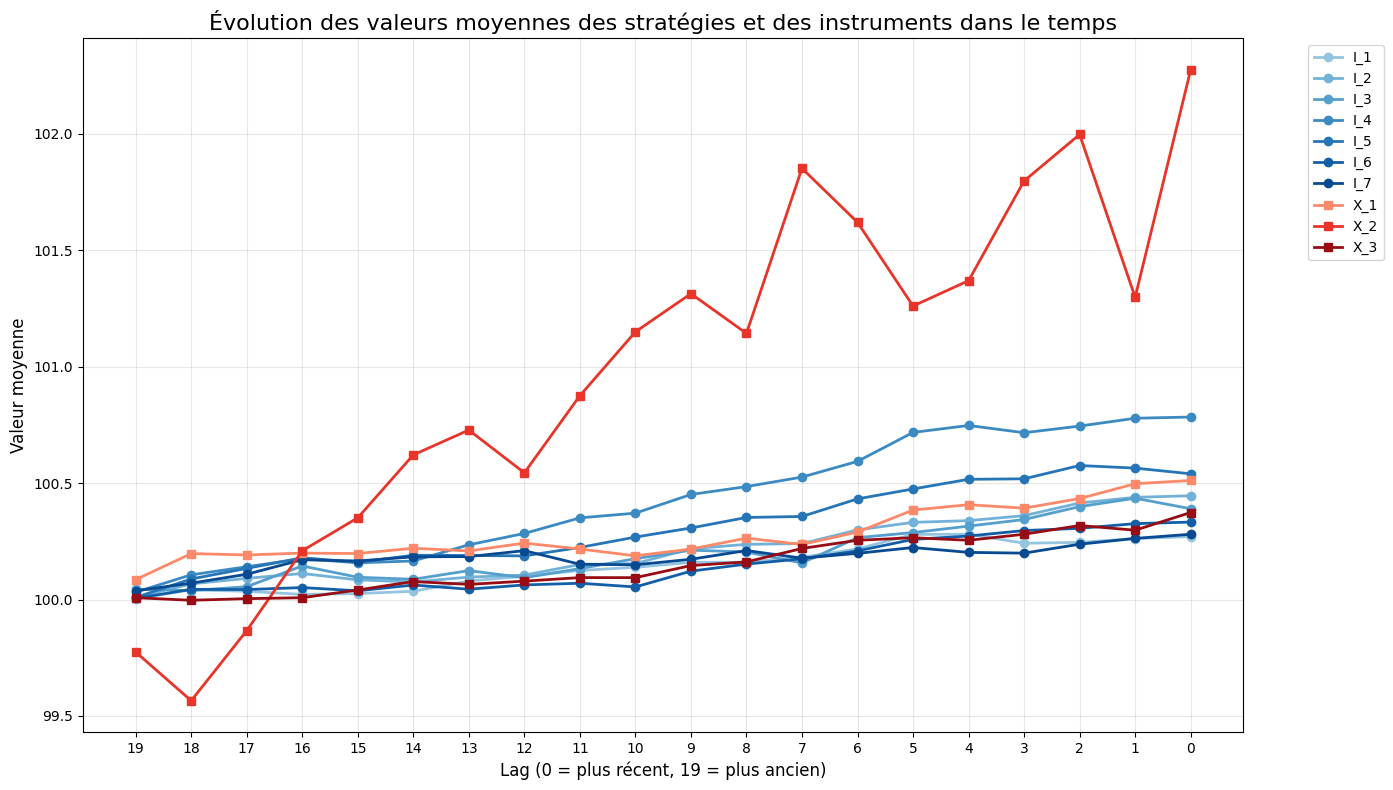

In [46]:
# Etape 2 : affichage
# Récupération des moyennes
means_by_element = extract_by_element_and_lag('mean', descriptive_features)

# On "inverse" les lags de sorte à ce que le graphique aille du plus ancien au plus récent
# 20 (données les plus anciennes) devient 0 par exemple
max_lag = means_by_element['lag'].max()
means_by_element['time'] = max_lag - means_by_element['lag']

# Eléments à visualiser
I_elements = [f'I_{i}' for i in range(1, 8)]
X_elements = [f'X_{i}' for i in range(1, 4)]

# Filtrage
filtered_means = means_by_element[means_by_element['element'].isin(I_elements + X_elements)]

# Création des graphiques et affichage
fig_means = create_line_chart(
    filtered_means,
    'mean',
    I_elements,
    X_elements,
    'Évolution des valeurs moyennes des stratégies et des instruments dans le temps',
    'Valeur moyenne'
)

plt.figure(fig_means.number)
plt.show()


On observe globalement des comportements fidèles à ceux attendus : les portefeuilles alloués aux différentes stratégies (I_1 à I_7) s'apprécient, de même que les valeurs des instruments (X_1 à X_3) qui sont inconnus. Cela témoigne d'une bonne performance des stratégies, tandis que l'interprétation des instruments est plus ardue, ceux-ci n'étant pas connus. L'instrument 2 (X_2) ressort évidemment, il offre un rendement sur 20 jours plus important en moyenne et semble plus volatile. Ces éléments nous confirment la nécessité de standardiser nos données afin d'équilibrer leur l'influence et d'éviter que des variables à forte dispersion ne dominent les algorithmes sensibles à l'échelle.

#### 2.3.2. Etudes descriptives de la variable cible



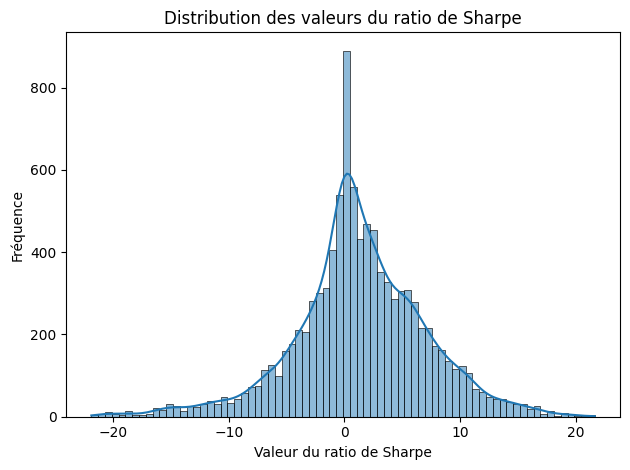

Skewness de la distribution des ratios de Sharpe : -0.263731357916495
Excès de kurtosis de la distribution des ratios de Sharpe : 1.251930574479156
===== Statistiques descriptives =====
count    9933.000000
mean        1.293375
std         5.806981
min       -21.902900
25%        -1.564104
50%         0.992727
75%         4.794639
max        21.665272
Name: Target, dtype: float64


In [47]:
# Histogramme
sns.histplot(labels["Target"], kde=True)
plt.xlabel("Valeur du ratio de Sharpe")
plt.ylabel("Fréquence")
plt.title('Distribution des valeurs du ratio de Sharpe')

plt.tight_layout()
plt.show()

# Skewness et kurtosis de la distribution des ratios de Sharpe
print(f"Skewness de la distribution des ratios de Sharpe : {labels['Target'].skew()}")
print(f"Excès de kurtosis de la distribution des ratios de Sharpe : {labels['Target'].kurt()}")

print("===== Statistiques descriptives =====")
print(labels["Target"].describe())

Ce graphique et ces valeurs nous permettent de faire plusieurs commentaires :
- La distribution des ratios de Sharpe est relativement symétrique mais légèrement décalée à gauche (skewness négatif),
- La distribution des ratios de Sharpe est leptokurtique, avec des queues de distribution plus épaisses qu'une distribution gaussienne. Cela est cohérent avec les faits stylisés des rendements financiers, qui ne suivent pas une distribution Normale.

Les ensembles de stratégies présentent un ratio de Sharpe annualisé moyen d'environ 1.3, ce qui se situe dans la tranche haute des valeurs usuelles des ratios de Sharpe. Cependant, l'élement le plus frappant reste la plage d'évolution de ce ratio, avec une étendue de plus de 40. On est donc face à des stratégies qui, certes, affichent de bonnes performances en moyenne, mais sont aussi très risquées. Cela se confirme par la volatilité du ratio de Sharpe.  Cette distribution étonnante, car beaucoup plus étalée (surpondération de valeurs intermédiaires et extrèmes) qu'une distribution de Sharpe classique souvent très compact autour de zéro, s'explique par plusieurs raisons. Tout d'abord la nature extrêmement volatile des cryptomonnaies, actifs principales des stratégies de Napoleon Crypto conduit à des stratégies volatiles et incertaines. Par ailleurs l'horizon considérée est extrèmement court (5 jours) ce qui renforce l'instabilité du ratio de Sharpe annualisé. 

#### 2.3.3. Corrélation entre les features

Intéressons-nous aux corrélations entre les features, des corrélations trop fortes entre les *features* (ou, comme nous raisonnons aussi avec des séries temporelles, des cas d'autocorrélation) peut réduire l'interprétabilité (difficile d'isoler l'effet individuel de chaque feature sur la prévision) et la performance du modèle (certains algorithmes sont sensibles à la multicolinéarité). En outre, cela peut aussi favoriser l'overfitting. Nous en profitons pour suprimer la colonne "lag_20" (identiques pour tout l'échantillon).

In [48]:
# Copies de sécurité
features_clean = features.copy()
labels_clean = labels.copy()

La représentation de la matrice de corrélation n'est pas simple étant donnée sa taille. Nous proposons deux approches :
- une approche par heatmap usuelle sur la partie triangulaire inférieure de la matrice. C'est une solution peu fine, mais elle permet de voir à vue d'oeil si les corrélations sont **globalement** fortes ou faibles entre les features ;
- un affichage de l'histogramme des corrélations. Si l'on s'aperçoit qu'un nombre conséquent de corrélations sont élevées, nous investiguerons davantage.
Nous procédons également au test de significativité des corrélations :
\begin{align*}
H_0 &: \rho_{X,Y} = 0 \\
H_1 &: \rho_{X,Y} \neq 0
\end{align*}

Avec $n$ le nombre d'observation, la statistique de test associée s'énonce :
\begin{align*}
t = \hat{\rho_{X,Y}} \times \sqrt{\frac{n-2}{1-\hat{\rho_{X,Y}}^2}} \sim St(n-2)
\end{align*}
Si la pvalue calculée est inférieure à 5% (seuil de risque de première espèce retenu), on rejette $H_0$. La fonction suivante traduit en code les éléments sus-mentionnés et permet de fournir l'analyse globale des corrélations de Pearson.

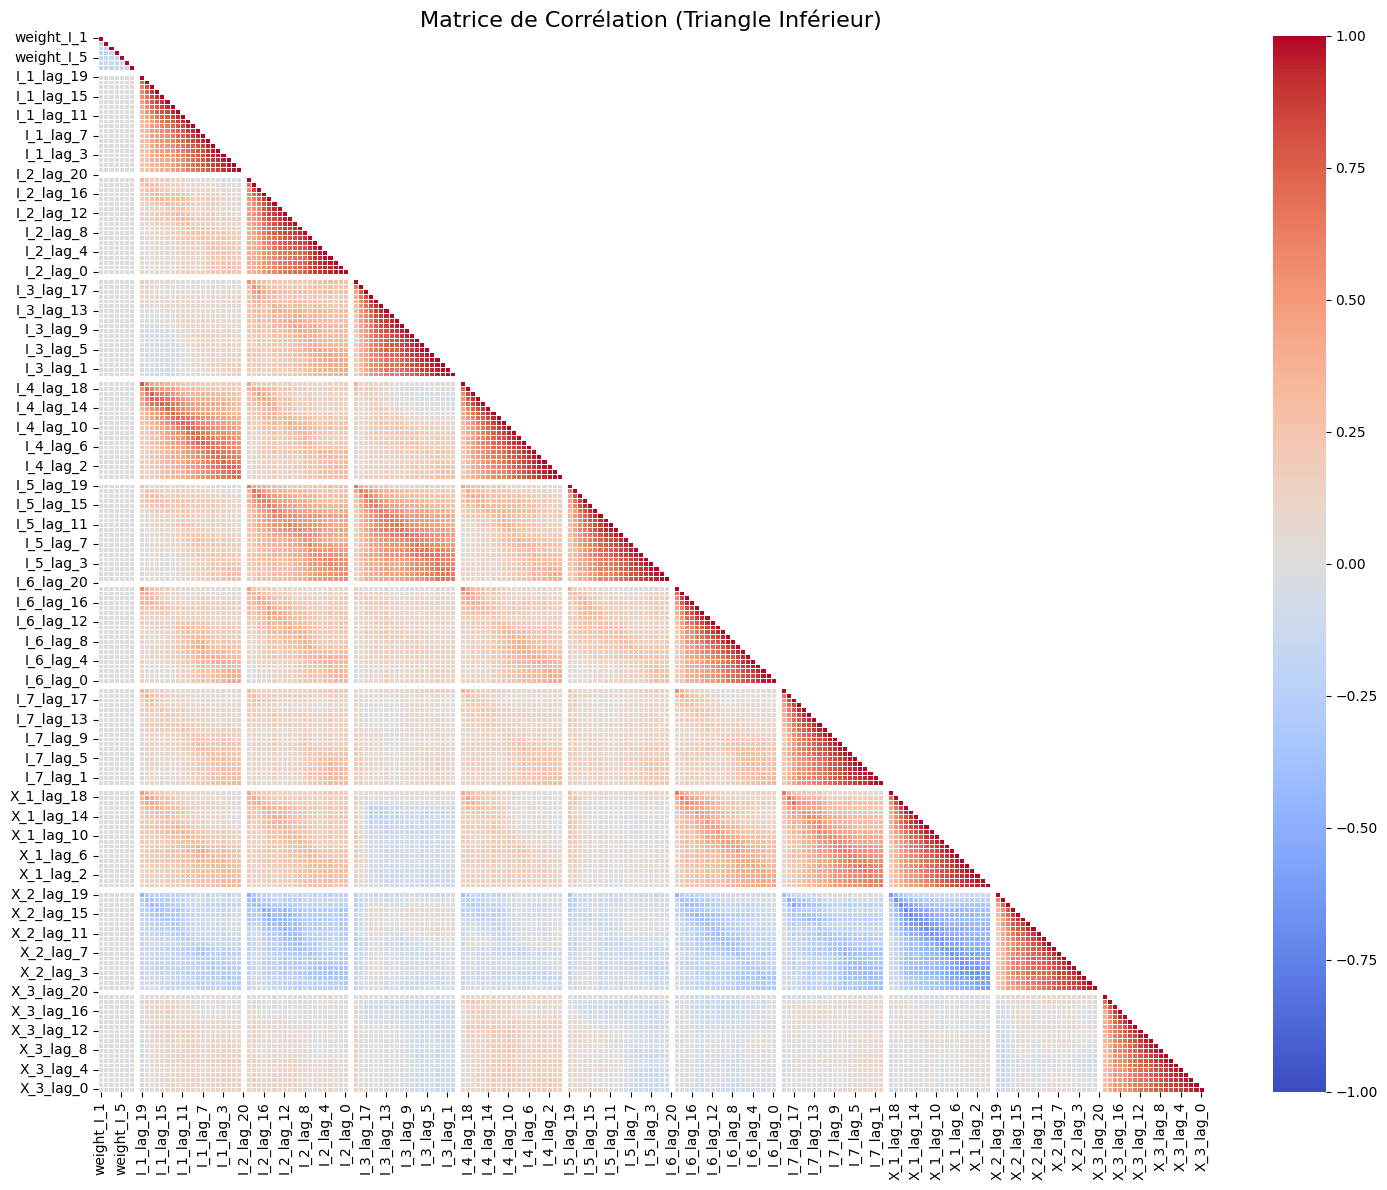

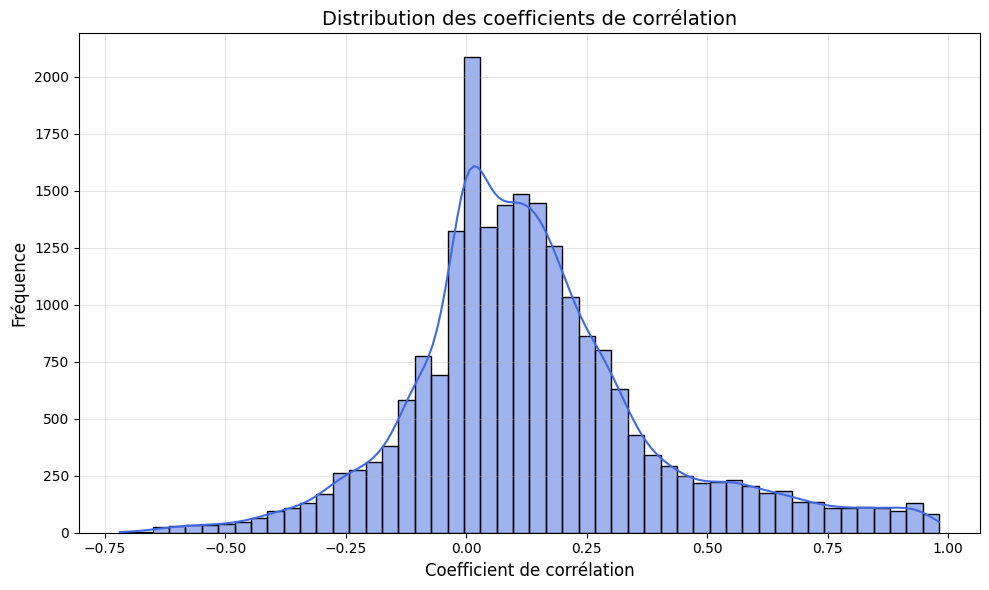

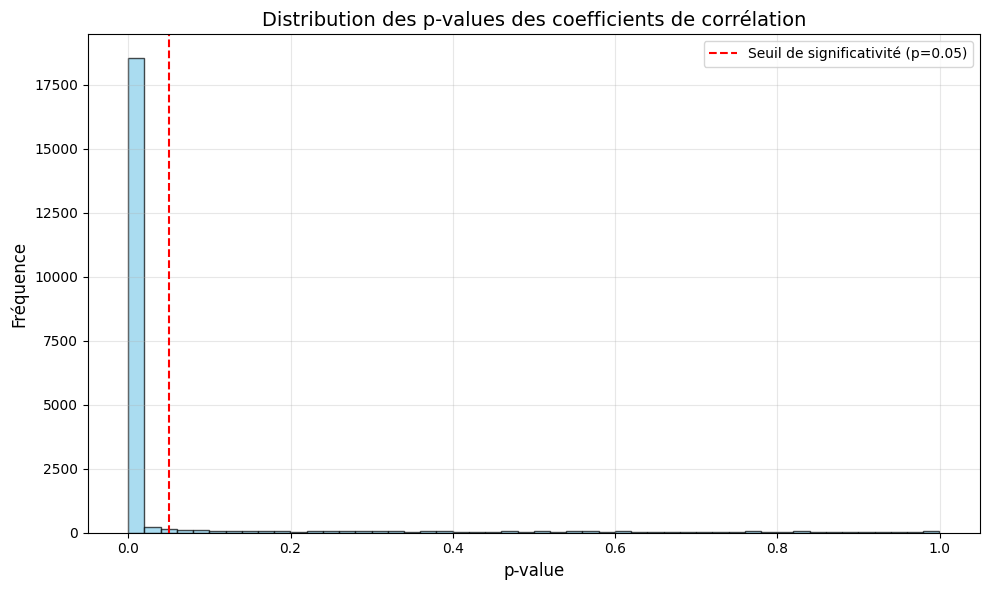

Nombre de corrélations testées : 23436
Nombre de corrélations significatives (p < 0.05) : 18833
Pourcentage de corrélations significatives : 80.36%


In [50]:
corr_matrix, significant_percent = analyze_correlations(
    df=features_clean,
    alpha=0.05
)

De ces graphiques, nous pouvons faire deux principales remarques :
- d'un côté, les séries temporelles des valeurs des stratégies ne semblent pas fortement corrélées entre elles, ni avec les poids (zones bleuâtres/grises sur la matrice de corrélation), ni avec les instruments financiers. Cela est positif, puisque cela suggère ces variables n'expliquent pas les mêmes éléments.
- d'un autre côté, de fortes corrélations positives existent au sein des séries temporelles. Cela reflète très probablement la présence d'autocorrélation dans les séries de prix, ce qui est un phénomène connu des marchés. La différenciation permet généralement d'aboutir à des séries stationnaires non autocorrélées. Nous reviendrons plus en détail sur ces points dans la suite.
- on observe que plus de 80% des variables ont une corrélation significative. Un traitement est donc nécessaire pour augmenter le champ d'information expliqué par les variables.

#### 2.3.4. Calcul des rendements

Les features que nous avons à notre disposition contiennent des séries de prix sur 21 jours. Le label final étant le ratio de Sharpe, calculé à partir des rendements des stratégies, nous allons transformer nos séries de prix en rendements (logarithmiques). Cette méthode devrait en outre permettre de **réduire, voire supprimer, l'autocorrélation** dans nos séries temporelles. Les rendements logarithmiques sont utilisés dans le calcul du ratio de Sharpe, ce sont donc ceux que nous utiliserons ici.

In [ ]:
# Dataframe avec poids et rendements
features_rdt = compute_returns(features_clean)
cols_rdt_20 = [col for col in features_rdt.columns if "lag_20" in col]
# On retire les colonnes "lag_20" car elles sont le résultat du calcul ln(X_i_lag_0/ X_j_lag_20)
features_rdt = features_rdt.drop(columns=cols_rdt_20)
display(features_rdt.head(5))

,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,rendement_X_3_lag_9,rendement_X_3_lag_8,rendement_X_3_lag_7,rendement_X_3_lag_6,rendement_X_3_lag_5,rendement_X_3_lag_4,rendement_X_3_lag_3,rendement_X_3_lag_2,rendement_X_3_lag_1,rendement_X_3_lag_0
ID,,,,,,,,,,,,,,,,,,,,,
0,0.15,0.00,0.05,0.80,0.00,0.0,0.00,0.000474,0.000111,-0.000109,...,0.003170,0.006595,0.003140,0.007522,0.000000,-0.000991,0.000283,0.000566,0.000848,0.001130
1,0.00,0.00,0.00,0.40,0.25,0.0,0.35,-0.000877,0.000482,0.002222,...,0.006313,0.000273,0.000547,0.001366,-0.003829,-0.002195,-0.002200,-0.000276,0.000276,0.002497
2,0.85,0.00,0.00,0.15,0.00,0.0,0.00,-0.005197,0.007191,0.002078,...,-0.001336,0.002076,-0.002670,0.004741,0.002215,-0.003250,0.000000,-0.006235,-0.003132,0.002238
3,0.00,0.00,0.70,0.05,0.25,0.0,0.00,0.001245,-0.001012,0.002725,...,0.001197,0.001941,0.000149,0.005059,0.001335,0.002664,-0.002368,0.001037,0.002365,-0.003846
4,0.00,0.55,0.05,0.00,0.00,0.0,0.40,0.000000,-0.005940,0.000109,...,0.005515,-0.001835,0.001224,0.004271,-0.001828,0.005777,0.000000,0.003935,0.000905,-0.000604


#### 2.3.5. Feature engineering

Nous cherchons à créer un certain nombre de features afin de capturer des dynamiques sous-jacentes plus complexes, qui nous permettront ensuite d'entraîner notre modèle. En plus des rendements journaliers, nous proposons les features suivants :
- covariances entre les rendements des stratégies, entre les rendements des indicateurs économiques et entre les rendements stratégies et les rendements indicateurs économiques (afin d'identifier d'éventuelles relations structurelles entre variables),
- volatilités des rendements (mesure de risque au dénominateur du ratio de Sharpe),
- ratios de Sharpe hebdomadaires (pour capturer une potentielle autocorrélation dans le ratio de Sharpe);
- skewness et kurtosis des rendements (permet de distinguer des stratégies dont la performance repose sur des événements extrêmes de celles qui performent régulièrement. Par exemple, deux stratégies peuvent avoir le même ratio de Sharpe, mais l'une présente une distribution des rendements leptokurtique asymétrique à gauche et donc avec des drawdowns potentiellement larges et réguliers, l'autre symétrique avec faible kurtosis),
- l'indice Herfindahl-Hirschman (HHI) comme mesure de la diversification (permet de voir si le ratio de Sharpe est meilleur lorsque l'AUM est alloué de manière diversifié ou non) :
$$
HHI = \sum_{i=1}^N \omega_i^2, \quad 0 < HHI \leq 1 \\
\begin{cases}
HHI = 1 : \text{ portefeuille totalement concentré} \\
HHI = \frac{1}{N} : \text{ portefeuille équipondéré}
\end{cases}
$$

In [53]:
features_total = process_features(features_rdt)
display(features_total.head(5))

features_rdt: (9933, 207)
new_features: (9933, 287)


,weight_I_1,weight_I_2,weight_I_3,weight_I_4,weight_I_5,weight_I_6,weight_I_7,rendement_I_1_lag_19,rendement_I_1_lag_18,rendement_I_1_lag_17,...,kurt_I_6,kurt_I_7,kurt_X_1,kurt_X_2,kurt_X_3,sharpe_week_1,sharpe_week_2,sharpe_week_3,sharpe_week_4,HHI
ID,,,,,,,,,,,,,,,,,,,,,
0,0.15,0.00,0.05,0.80,0.00,0.0,0.00,0.000474,0.000111,-0.000109,...,3.811761,3.535207,-0.484368,-1.019894,1.764071,-1.925208,7.977686,-2.132942,-8.615628,0.665
1,0.00,0.00,0.00,0.40,0.25,0.0,0.35,-0.000877,0.000482,0.002222,...,6.990684,-0.476448,-0.476448,1.147579,-0.128676,6.285693,6.709467,0.803147,17.656251,0.345
2,0.85,0.00,0.00,0.15,0.00,0.0,0.00,-0.005197,0.007191,0.002078,...,2.673641,-0.034851,-0.034851,-0.130658,-0.902351,7.726733,-1.166057,9.987583,5.182329,0.745
3,0.00,0.00,0.70,0.05,0.25,0.0,0.00,0.001245,-0.001012,0.002725,...,3.672120,0.517233,0.517233,-0.909922,-0.772276,5.733866,6.685264,-7.017447,-1.944735,0.555
4,0.00,0.55,0.05,0.00,0.00,0.0,0.40,0.000000,-0.005940,0.000109,...,3.000790,-0.088999,-0.117941,-0.640775,0.913934,3.883034,-0.671889,3.744763,-4.886388,0.465


Après ces calculs, on constate que certaines colonnes affichent des valeurs vides (NaN). Plus précisément, on identifie qu'elles sont présentes dans les skewness et kurtosis des rendements calculés en $t-4$ et $t-6$. On décide de supprimer ces colonnes. En effet, le nombre conséquent de valeurs vides dans ces 4 colonnes rend difficile la justification d'un remplacement par une valeur. De plus, le nombre important de données à notre disposition devrait rendre marginal l'effet de ces suppressions.

In [54]:
features_total = features_total.drop(["skew_I_6", "kurt_I_6", "skew_I_4", "kurt_I_4"], axis = 1)

In [55]:
pd.options.display.max_rows = None
print(f"Le fichier de données contient {features_total.isna().sum().sum()} données manquantes.")

Le fichier de données contient 0 données manquantes.


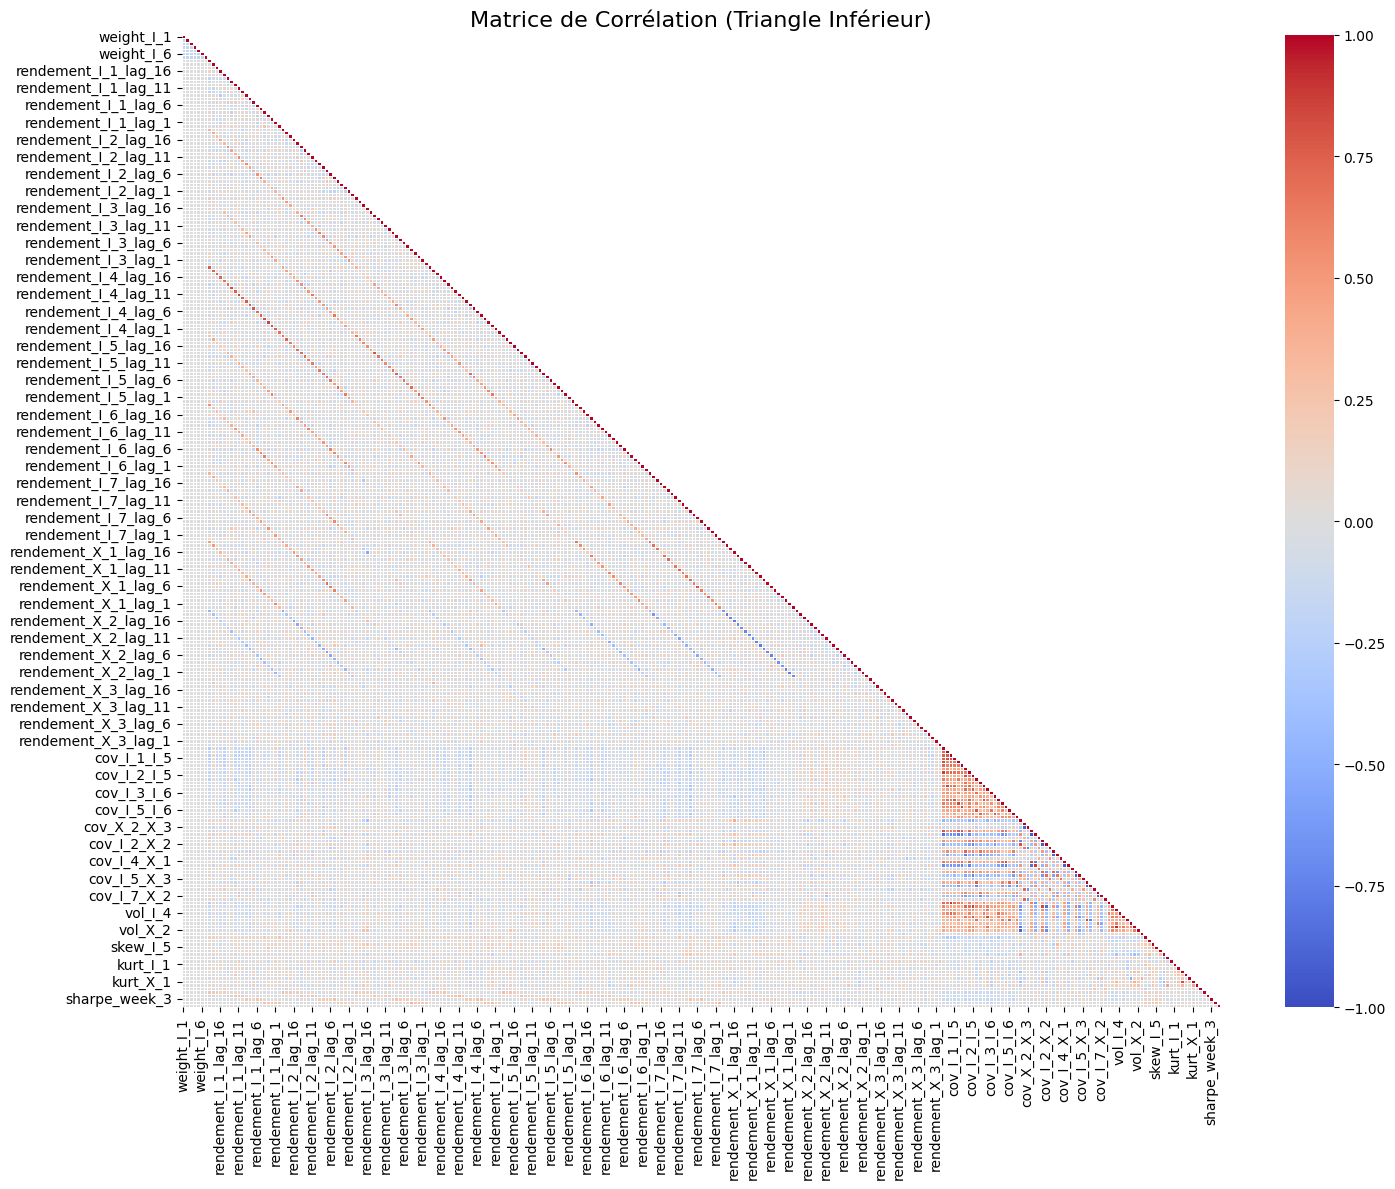

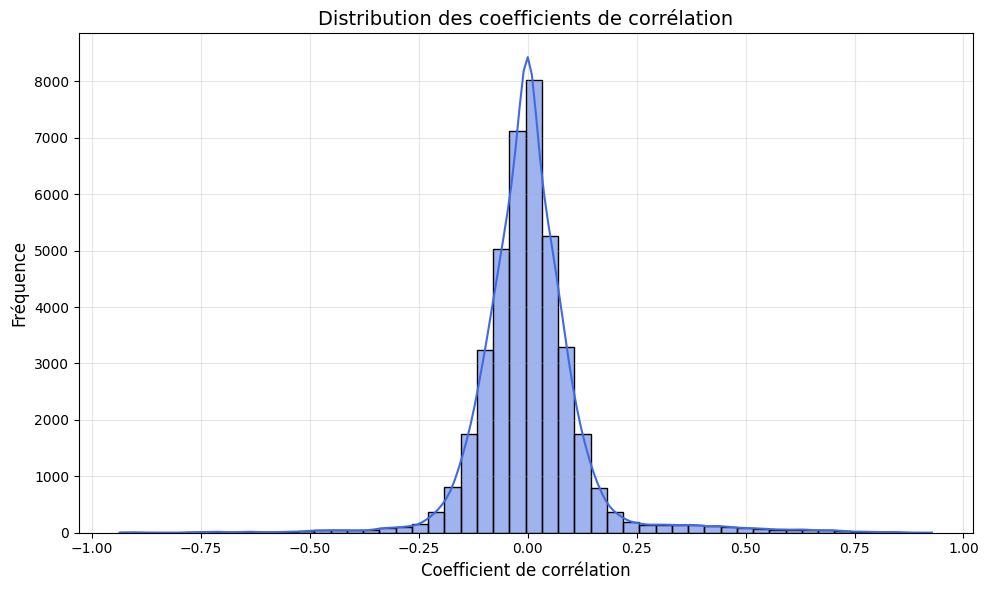

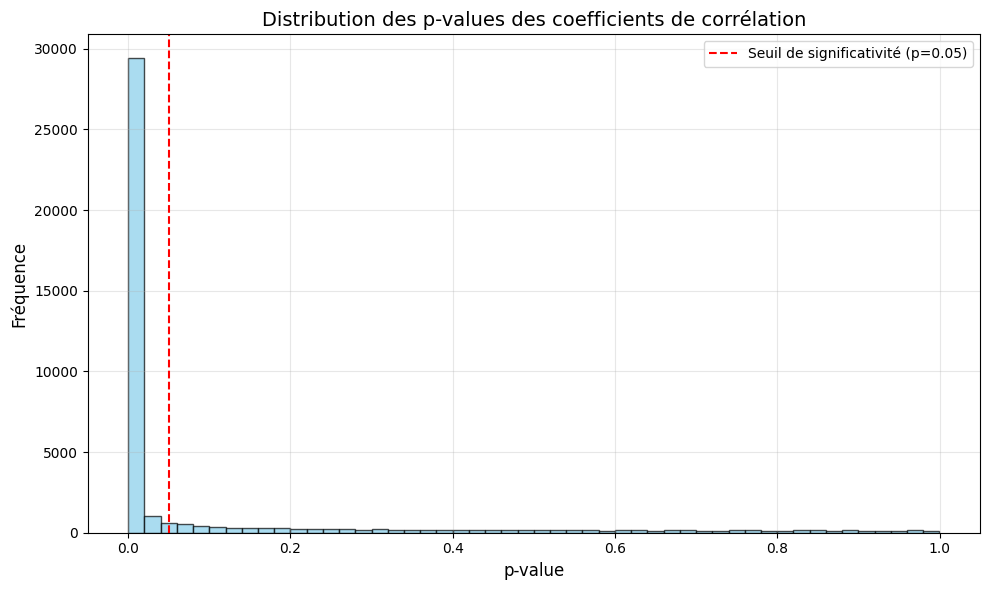

Nombre de corrélations testées : 39903
Nombre de corrélations significatives (p < 0.05) : 30751
Pourcentage de corrélations significatives : 77.06%


In [56]:
new_corr_matrix, new_significant_percent = analyze_correlations(features_total)

#### 2.3.6. Corrélation entre les features et la cible

In [57]:
print(labels_clean.info())
print(features_total.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9933 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  9933 non-null   float64
dtypes: float64(1)
memory usage: 155.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 9933 entries, 0 to 9999
Columns: 283 entries, weight_I_1 to HHI
dtypes: float64(283)
memory usage: 21.8 MB
None


In [58]:
merge_for_corr = features_total.join(labels_clean)
print(merge_for_corr.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9933 entries, 0 to 9999
Columns: 284 entries, weight_I_1 to Target
dtypes: float64(284)
memory usage: 21.9 MB
None


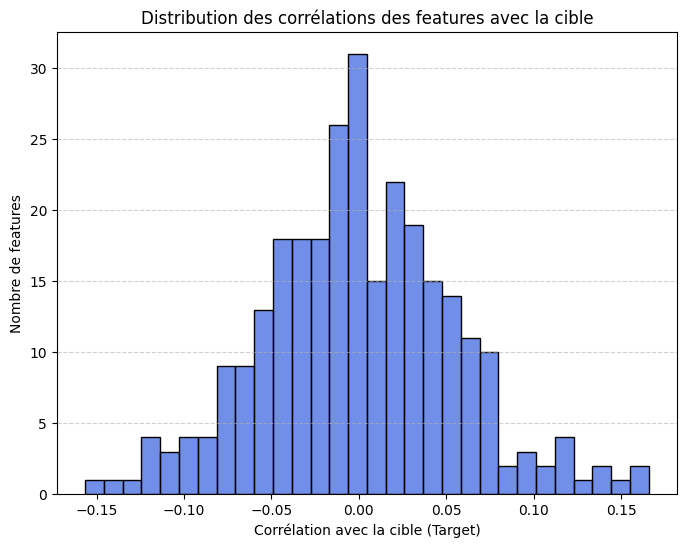

In [59]:
corr_label = merge_for_corr.corr()
corr_target = corr_label["Target"].drop("Target")
n = len(corr_label)
pvalues = corr_target.apply(lambda r: pearson_pvalue(r, n))

# Histogramme des corrélations
plt.figure(figsize=(8, 6))
sns.histplot(corr_target, bins=30, kde=False, color="royalblue")
plt.xlabel("Corrélation avec la cible (Target)")
plt.ylabel("Nombre de features")
plt.title("Distribution des corrélations des features avec la cible")
plt.grid(axis="y", linestyle="--", alpha=0.6)

Le graphique met en évidence que les corrélations marginales entre les variables explicatives et le ratio de Sharpe futur sont globalement faibles et centrées autour de zéro. Ce résultat est cohérent avec la nature du problème étudié. 

En effet, le ratio de Sharpe est une mesure de performance complexe et non linéaire, qui dépend conjointement des rendements futurs, des volatilités, des covariances entre stratégies et des pondérations du portefeuille. Il est donc peu probable qu’une variable prise isolément présente une corrélation linéaire élevée avec cette cible, en particulier sur un horizon très court de cinq jours et dans un contexte de marchés de cryptomonnaies fortement volatils.

La faiblesse des corrélations marginales indique ainsi que le signal prédictif potentiel, s’il existe, réside principalement dans des interactions entre variables plutôt que dans des effets linéaires simples. Cela implique que la prédiction du ratio de Sharpe est intrinsèquement difficile, mais pas impossible, et justifie le recours à des modèles non linéaires capables de capter des dépendances complexes.

La problématique proposée par Napoleon est ambitieuse car prédire un ratio de Sharpe hebdomadaire est une tache complexe. Il y a plusieurs raisons à cela, premièrement, les rendements financiers sont très peu autocorrélés contrairement à la volatilités ou aux prix. C'est le cas dans nos données, les rendements des stratégies ne présentent pas d'autocorrélations, en revanche aux mêmes dates les rendements de différentes stratégies peuvent être corrélées. En l'absence d'autocorrélation, la prédiction de rendement et donc du ratio de Sharpe (qui necessite une prédiction sur cinq jours) est difficile. Les rendements étant presque imprévisibles et la volatilité étant très instable, le ratio de Sharpe futur hebomadaire est très bruité et surement peu lié aux informations passées. Ce bruit est amplifié par l'annualisation. Le graphique ci-dessus montre des corrélations entre notre cible et nos features très faibles et confirment que le signal est faible. 

### 2.4 Séparation du dataset

La division des données d’entraînement en jeux d’apprentissage et de validation est indispensable afin d’évaluer la capacité de généralisation du modèle. Dans notre cas, cette séparation requiert une attention particulière. En effet, notre dataset est construit à partir de fenêtres temporelles de 21 jours, chaque trajectoire de marché étant réutilisée jusqu’à 50 fois avec différentes combinaisons de poids appliquées aux stratégies. Deux observations distinctes peuvent ainsi correspondre à la même série temporelle sous-jacente, différant uniquement par leur pondération.

Afin d’éviter tout data leakage, il est donc impératif que deux observations partageant la même trajectoire de prix ne puissent jamais être réparties entre des ensembles d’apprentissage et de validation (ou de test). Autrement dit, toutes les “prises de vue” d’un même scénario de marché doivent être traitées comme une unité indivisible.

Pour répondre à cette contrainte, nous définissons des groupes d’observations à partir de la valeur finale d’une stratégie donnée (arbitrairement la deuxième, I_2_lag_0). Comme chaque stratégie est normalisée à 100 au début de chaque fenêtre, deux observations présentant exactement la même valeur finale pour cette stratégie correspondent nécessairement à la même trajectoire de 21 jours, indépendamment des poids appliqués. Ces observations sont donc regroupées sous un identifiant de groupe unique.

Dans un premier temps, nous procédons à une séparation explicite d’un jeu de test. Cette séparation est réalisée à l’aide de GroupShuffleSplit, qui sélectionne aléatoirement une fraction des groupes pour constituer le jeu de test et celui de validation, tout en garantissant qu’aucun groupe n’est partagé entre les ensembles train, validation et test. La répartition finale est 60% dans le train set, 20% dans le validation set et 20% dans le set de test. Cette étape permet d’obtenir une évaluation finale totalement indépendante, réalisée sur des séries temporelles jamais observées durant la phase de sélection du modèle.

In [60]:
# copie pour éviter toute modification involontaire
fc = features_clean.copy()

# Création des groupes à partir des trajectoires complètes sur 21 jours
ts_cols = [c for c in fc.columns if "_lag_" in c]
if len(ts_cols) == 0:
    raise ValueError("No *_lag_* columns found in features_clean. Adapt ts_cols selection.")

fc["Group"] = pd.util.hash_pandas_object(fc[ts_cols].round(6), index=False).astype("int64")
groups_all = fc["Group"].to_numpy()
idx_all = fc.index.to_numpy()

# Découpage en Train+Val et Test, puis en Train et Val
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
trval_pos, test_pos = next(gss1.split(idx_all, groups=groups_all))

idx_trval = idx_all[trval_pos]
idx_test  = idx_all[test_pos]

groups_trval = groups_all[trval_pos]

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
tr_pos, val_pos = next(gss2.split(idx_trval, groups=groups_trval))

idx_train = idx_trval[tr_pos]
idx_val   = idx_trval[val_pos]

# Construction des jeux de données finaux
X_train = features_total.loc[idx_train].copy()
X_val   = features_total.loc[idx_val].copy()
X_test  = features_total.loc[idx_test].copy()

Y_train = labels_clean.loc[idx_train].copy()
Y_val   = labels_clean.loc[idx_val].copy()
Y_test  = labels_clean.loc[idx_test].copy()

# Groupes associés à chaque split (utile pour vérifications)
groups_train = fc.loc[idx_train, "Group"].to_numpy()
groups_val   = fc.loc[idx_val, "Group"].to_numpy()
groups_test  = fc.loc[idx_test, "Group"].to_numpy()

print("Split sizes:")
print("  Train:", len(X_train), "obs |", len(np.unique(groups_train)), "groups")
print("  Val  :", len(X_val),   "obs |", len(np.unique(groups_val)),   "groups")
print("  Test :", len(X_test),  "obs |", len(np.unique(groups_test)),  "groups")

print("\nTarget summary (mean / median):")
for name, yy in [("Train", Y_train["Target"]), ("Val", Y_val["Target"]), ("Test", Y_test["Target"])]:
    print(f"  {name}: mean={yy.mean():.4f}  median={yy.median():.4f}  std={yy.std():.4f}")


Split sizes:
  Train: 5958 obs | 120 groups
  Val  : 1990 obs | 40 groups
  Test : 1985 obs | 40 groups

Target summary (mean / median):
  Train: mean=1.3927  median=0.9046  std=5.6765
  Val: mean=1.2793  median=1.2283  std=6.0447
  Test: mean=1.0093  median=0.9811  std=5.9430


Nous vérifions manuellement si la séparation a fonctionné comme souhaité et que chaque groupe d’observations contenant les mêmes séries temporelles se retrouve bien dans un seul et même ensemble. Si deux observations avec les mêmes séries temporelles (mais des poids différents) s’étaient par exemple retrouvées l’une dans le jeu d’entraînement et l’autre dans le jeu de test, il y aurait alors eu du data leakage.

Pour effectuer une vérification supplémentaire, nous sélectionnons un groupe d’observations partageant la même série temporelle (50 observations) dans nos données et vérifions que ce groupe est présent dans un unique ensemble. Nous présentons d’abord les premières vérifications, qui consistent à s’assurer que les 50 indices appartiennent bien au même ensemble.

In [61]:
print((X_test.index == 6).sum()) # dans nos datas 6 est le premier index du groupes de 50 observations 
print((Y_test.index == 6).sum())
print((X_test.index == 109).sum()) 
print((Y_test.index == 109).sum())
print((X_test.index == 435).sum()) 
print((Y_test.index == 435).sum())
print((X_test.index == 921).sum()) 
print((Y_test.index == 921).sum())

# ...

1
1
1
1
1
1
1
1


La train set contient 7948 observations, et le test set en contient 1985. 

Nous suprimons des outliers sur le train set, pour qu'ils n'aient pas trop d'impact sur l'estimation. La prédiction et l'évalutation se feront sur les données d'origines, sans suppression d'outiliers. 

In [62]:
y = Y_train["Target"]  

Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

k = 2.0  
lower = Q1 - k * IQR
upper = Q3 + k * IQR

mask = (y >= lower) & (y <= upper)   #  Series Boolenne indexé comme X_train/Y_train

print(f"TRAIN obs avant filtrage : {len(Y_train)}")
print(f"TRAIN obs après filtrage : {int(mask.sum())}")
print(f"IQR filter bounds: [{lower:.3f}, {upper:.3f}]")

# Filtre train seule
X_train = X_train.loc[mask].copy()
Y_train = Y_train.loc[mask].copy()


TRAIN obs avant filtrage : 5958
TRAIN obs après filtrage : 5853
IQR filter bounds: [-14.313, 17.735]


## 3. Prédiction

Les modèles sont entraînés exclusivement sur un jeu d’apprentissage, tandis que leurs hyperparamètres sont sélectionnés sur un jeu de validation disjoint, afin de contrôler la complexité et d’éviter toute fuite d’information. Le modèle retenu est ensuite ré-entraîné sur l’ensemble apprentissage-validation avant d’être évalué une seule fois sur un jeu de test indépendant. 

La métrique retenue est la MAE qui est moins sensible aux erreurs extrêmes que le RMSE, car celles-ci ne sont pas amplifiées par une mise au carré. Cela est particulièrement pertinent dans notre contexte, où le ratio de Sharpe présente une forte dispersion et peut prendre des valeurs très élevées en valeur absolue. La RMSE pourrait trop pénaliser certaines grosses erreurs et être moins représentatif que la MAE. 

Les données utilisées sont de dimension élevée, avec un grand nombre de variables explicatives. Malgré la transformation en rendements, qui permet de réduire l’autocorrélation temporelle, une corrélation significative subsiste entre certaines variables, notamment entre stratégies observées à une même date. De plus, les relations entre les prédicteurs et la variable cible sont susceptibles d’être non linéaires et d’impliquer des interactions complexes. Dans ce contexte, il est nécessaire de recourir à des modèles capables de gérer à la fois la forte dimension, la colinéarité et la complexité des relations, tout en limitant le risque de sur-apprentissage.


### 3.1 Benchmark

On observe un modèle de référence naïf qui prédit systématiquement la moyenne du label observée sur l’ensemble d’apprentissage, afin de disposer d’un point de comparaison minimal pour l’évaluation des modèles. 

In [64]:
print(Y_train.describe())

            Target
count  5853.000000
mean      1.641645
std       5.122956
min     -14.311096
25%      -1.293142
50%       0.971669
75%       4.940975
max      17.708526


In [65]:
bench_const = float(Y_train.mean())
bench_pred = np.full_like(Y_test.values, bench_const, dtype=float)

bench_score = mean_absolute_error(Y_test.values, bench_pred)

print("Benchmark const (train mean):", bench_const)
print("Benchmark MAE:", bench_score)

Benchmark const (train mean): 1.6416448038594118
Benchmark MAE: 4.4525879924565235


### 3.2 Elasticnet

Le premier modèle testé est un modèle de régression Elastic Net, qui est linéaire et interprétable. Ce modèle de régression combine pénalités L1 et L2 afin de gérer un grand nombre de variables potentiellement corrélées. Les variables explicatives sont standardisées avant estimation. L’Elastic Net est particulièrement adapté à nos données car le grand nombre de variables et leurs corrélations empêchent l'utilisation de modèles interprétables de régression sans régularisation. Sa régularisation combinant les modèles Ridge et Lasso permet une sélection de variables souple, évitant ainsi d’écarter arbitrairement des prédicteurs proches. Sa structure linéaire permet en outre une interprétation économique claire des effets estimés.

#### Elasticnet - Modèle (1)

In [78]:
# Pipeline simple : standardisation + ElasticNet
pipe_simple = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(random_state=cfg.seed, max_iter=40_000, tol=1e-3))
])

# Espace de recherche des hyperparamètres
space = {
    "model__alpha": np.logspace(-5, 1, 50),
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# Cibles sous forme de tableaux 1D
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# Initialisation du meilleur modèle
best_val = 1e18
best_params = None
best_pipe = None

# Recherche aléatoire des hyperparamètres sur le jeu de validation
for params in ParameterSampler(space, n_iter=cfg.n_iter_fast, random_state=cfg.seed):
    p = clone(pipe_simple)
    p.set_params(**params)
    p.fit(X_train, ytr)
    pv = p.predict(X_val).ravel()
    s = mean_absolute_error(yva, pv)
    if s < best_val:
        best_val = s
        best_params = params
        best_pipe = p

print("Best VAL (simple enet):", best_val, "params:", best_params)

# Ré-entraînement sur Train + Validation
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva])

enet_1 = clone(pipe_simple).set_params(**best_params)
enet_1.fit(X_trval, y_trval)

# Évaluation finale sur le jeu de test
pt = enet_1.predict(X_test).ravel()
print("TEST mae (simple enet):", mean_absolute_error(yte, pt))

# Calcul de la corrélation (gestion du cas variance nulle)
if np.std(pt) < 1e-12:
    corr = 0.0
else:
    corr = np.corrcoef(pt, yte)[0, 1]

std_pred = np.std(pt)
print("corr(pred, y):", corr)
print("std(pred):", std_pred)
print("std(y):", np.std(yte))

Best VAL (simple enet): 4.75464199306422 params: {'model__l1_ratio': 0.5, 'model__alpha': np.float64(0.5963623316594636)}
TEST mae (simple enet): 4.336246844332189
corr(pred, y): 0.22665361357763456
std(pred): 1.4580861359654949
std(y): 5.9414764960521165


Le modèle Elastic Net (1) retient un paramètre de régularisation (alpha) de 0,6 ce qui est élevé. Le modèle est donc fortement régularisé. Le ratio l1 sélectionné est de 0,5 la régularisation est donc mixte, ce qui indique à la fois une sélection de variable et des coefficients faibles. C'est un résultat logique au vu du nombre de features et du faible signal. Par curiosité nous testons également le même modèle mais avec une grille d'hyperparamètres plus ''agressive'' : alpha maximum est 0,1. L'idée est de "forcer" le modèle à être moins régularisé et à produire des données plus dispersées pour tenter de répliquer la variance et donc la distribution de notre cible. Cette tentative échoue (MAE $>$ 5) ce qui indique un fort overfitting de ce modèle qui qui capte trop de bruits propres aux données d'entraînement.  

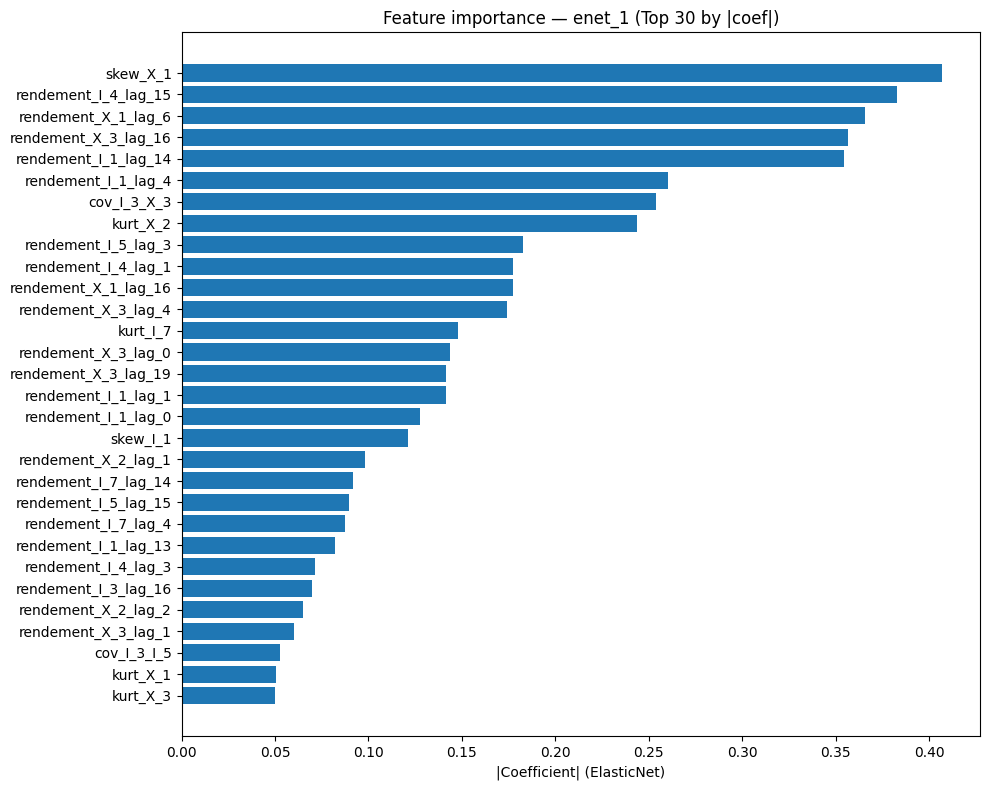

In [80]:
#  Feature importance pour ElasticNet (enet_1) 
enet_model = enet_1.named_steps["model"]
coefs = enet_model.coef_.ravel()

feature_names = X_trval.columns  # mêmes colonnes que celles utilisées à l'entraînement

fi_enet_1 = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "importance_abs": np.abs(coefs), # pour elastic Net l'importance des features est la valeur absolue des coefficients
}).sort_values("importance_abs", ascending=False).reset_index(drop=True)

# --- Plot top K ---
top_k = 30
fi_top = fi_enet_1.head(top_k).iloc[::-1]  # reverse pour un barh lisible

plt.figure(figsize=(10, 8))
plt.barh(fi_top["feature"], fi_top["importance_abs"])
plt.xlabel("|Coefficient| (ElasticNet)")
plt.title(f"Feature importance — enet_1 (Top {top_k} by |coef|)")
plt.tight_layout()
plt.show()

#### Elastic Net - Modèle test "agressif"

In [67]:
pipe_simple = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(random_state=cfg.seed, max_iter=40_000, tol=1e-3))
])

space_force = {
    "model__alpha": np.logspace(-5, -1, 30),     
    "model__l1_ratio": [0.3, 0.5, 0.7, 0.9]
}

ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

best_val = 1e18
best_params = None
best_pipe = None

for params in ParameterSampler(space_force, n_iter=cfg.n_iter_fast, random_state=cfg.seed):
    p = clone(pipe_simple)
    p.set_params(**params)
    p.fit(X_train, ytr)
    pv = p.predict(X_val).ravel()
    s = mean_absolute_error(yva, pv)
    if s < best_val:
        best_val = s
        best_params = params
        best_pipe = p

print("Best VAL (simple enet):", best_val, "params:", best_params)

# refit train+val
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva])

final = clone(pipe_simple).set_params(**best_params)
final.fit(X_trval, y_trval)

pt = final.predict(X_test).ravel()
print("TEST mae (simple enet):", mean_absolute_error(yte, pt))


if np.std(pt) < 1e-12:
    corr = 0.0
else:
    corr = np.corrcoef(pt, yte)[0, 1]

std_pred = np.std(pt)
print("corr(pred, y):", corr)
print("std(pred):", std_pred)
print("std(y):", np.std(yte))

Best VAL (simple enet): 5.888162209909316 params: {'model__l1_ratio': 0.9, 'model__alpha': np.float64(0.03856620421163472)}
TEST mae (simple enet): 6.077538484154398
corr(pred, y): 0.03561185733263747
std(pred): 5.498880984425481
std(y): 5.9414764960521165


### 3.3 RandomForest 

#### RandomForest - Modèle (2)

In [68]:
# Pipeline Random Forest (pas de normalisation nécessaire)
rf = Pipeline([
    ("model", RandomForestRegressor(
        random_state=cfg.seed,
        n_jobs=-1
    ))
])

# Espace de recherche des hyperparamètres (volontairement limité)
rf_space = {
    "model__n_estimators": [500, 800, 1200],
    "model__max_depth": [None, 10, 14],
    "model__min_samples_leaf": [2, 4, 8, 16],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],
}

# Cibles sous forme de tableaux 1D
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# Recherche des hyperparamètres sur le jeu de validation
best_val = np.inf
best_params = None
best_pipe = None

for i, params in enumerate(
    ParameterSampler(rf_space, n_iter=cfg.n_iter_fast, random_state=cfg.seed),
    start=1
):
    pipe = clone(rf)
    pipe.set_params(**params)
    pipe.fit(X_train, ytr)

    pred_val = pipe.predict(X_val)
    val_score = mean_absolute_error(yva, pred_val)

    print(f"[{i:02d}/{cfg.n_iter_fast}] VAL={val_score:.4f}  params={params}")

    if val_score < best_val:
        best_val = val_score
        best_params = params
        best_pipe = pipe

print("\nRF best on VAL:", best_val)
print("Best params:", best_params)

# Ré-entraînement sur Train + Validation
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

rf_final = clone(rf)
rf_final.set_params(**best_params)
rf_final.fit(X_trval, y_trval)

# Évaluation finale sur le jeu de test
pred_test = rf_final.predict(X_test)
test_score = mean_absolute_error(yte, pred_test)

print("MAE:", test_score)

# Diagnostics simples
print("corr(pred,y):", np.corrcoef(pred_test, yte)[0,1])
print("std(pred) / std(y):", np.std(pred_test), np.std(yte))


[01/10] VAL=4.4404  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 16, 'model__max_features': 'sqrt', 'model__max_depth': 10}
[02/10] VAL=4.5604  params={'model__n_estimators': 800, 'model__min_samples_split': 20, 'model__min_samples_leaf': 4, 'model__max_features': 0.3, 'model__max_depth': None}
[03/10] VAL=4.5981  params={'model__n_estimators': 800, 'model__min_samples_split': 20, 'model__min_samples_leaf': 2, 'model__max_features': 0.5, 'model__max_depth': 10}
[04/10] VAL=4.5491  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 0.3, 'model__max_depth': 14}
[05/10] VAL=4.4620  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 14}
[06/10] VAL=4.4621  params={'model__n_estimators': 800, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': '

Le modèle Random Forest (2) avec sélection d'hyperparamètres sur le validation set est aussi un modèle assez peu complexe et peu flexible. Cela est confirmé par la très faible variance de la prédiction qui indique que la considération de relation non linéaires permise par une Random Forest n'améliore pas la prévision. Si des relations non-linéaires existent entre les features et la cible alors elles sont trop instables pour être utilisées. Ce résultat montre que les relations entre notre cible et nos features sont instables et bruités ce qui obligent les modèles à être fortement régularisés. Le modèle sélectionne un grand nombre d'arbre, et un nombre de variable candidates à chaque split égale à $log_2(n)$. Ce dernier paramètre indique que peu de variable sont considérées pour chaque split, ce qui ajoute de l'aléa dans le modèle qui est donc assez fortement régularisé. 

#### RandomForest - Modèle (3) : ExtraTrees

In [69]:
# Imports
etr = Pipeline([
    ("model", ExtraTreesRegressor(
        random_state=cfg.seed,
        n_jobs=-1,
        bootstrap=False  # ExtraTrees standard
    ))
])

# Espace de recherche des hyperparamètres
etr_space = {
    "model__n_estimators": [500, 800, 1200],
    "model__max_depth": [None, 10, 14],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", 0.3, 0.5],
    # Paramètre optionnel si besoin de stabiliser :
    # "model__min_impurity_decrease": [0.0, 1e-6, 1e-5],
}

# Cibles sous forme de tableaux 1D
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# Recherche des hyperparamètres sur le jeu de validation
best_val = np.inf
best_params = None
best_pipe = None

for i, params in enumerate(
    ParameterSampler(etr_space, n_iter=cfg.n_iter_fast, random_state=cfg.seed),
    start=1
):
    pipe = clone(etr)
    pipe.set_params(**params)
    pipe.fit(X_train, ytr)

    pred_val = pipe.predict(X_val)
    val_score = mean_absolute_error(yva, pred_val)

    print(f"[{i:02d}/{cfg.n_iter_fast}] VAL={val_score:.4f}  params={params}")

    if val_score < best_val:
        best_val = val_score
        best_params = params
        best_pipe = pipe

print("\nExtraTrees best on VAL:", best_val)
print("Best params:", best_params)

# Ré-entraînement sur Train + Validation
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

etr_final = clone(etr)
etr_final.set_params(**best_params)
etr_final.fit(X_trval, y_trval)

# Évaluation finale sur le jeu de test
pred_test = etr_final.predict(X_test)
test_score = mean_absolute_error(yte, pred_test)

print("MAE:", test_score)

# Diagnostics simples
corr = np.corrcoef(pred_test, yte)[0, 1] if np.std(pred_test) > 1e-12 else 0.0
print("corr(pred,y):", corr)
print("std(pred) / std(y):", np.std(pred_test), np.std(yte))


[01/10] VAL=4.3963  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 8, 'model__max_features': 'sqrt', 'model__max_depth': 10}
[02/10] VAL=4.4608  params={'model__n_estimators': 800, 'model__min_samples_split': 20, 'model__min_samples_leaf': 2, 'model__max_features': 0.3, 'model__max_depth': None}
[03/10] VAL=4.4617  params={'model__n_estimators': 800, 'model__min_samples_split': 20, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': 10}
[04/10] VAL=4.4809  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 0.3, 'model__max_depth': 14}
[05/10] VAL=4.4095  params={'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 14}
[06/10] VAL=4.4283  params={'model__n_estimators': 800, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 's

Les conclusions précédentes sont confirmées par le résultat du modèle ExtraTrees qui introduit de l'aléa supplémentaire par rapport à une Random Forest, réduisant la variance. Ce modèle se prête donc mieux à nos données qu'une Random Forest car il se généralise mieux sur de nouvelles observations. 

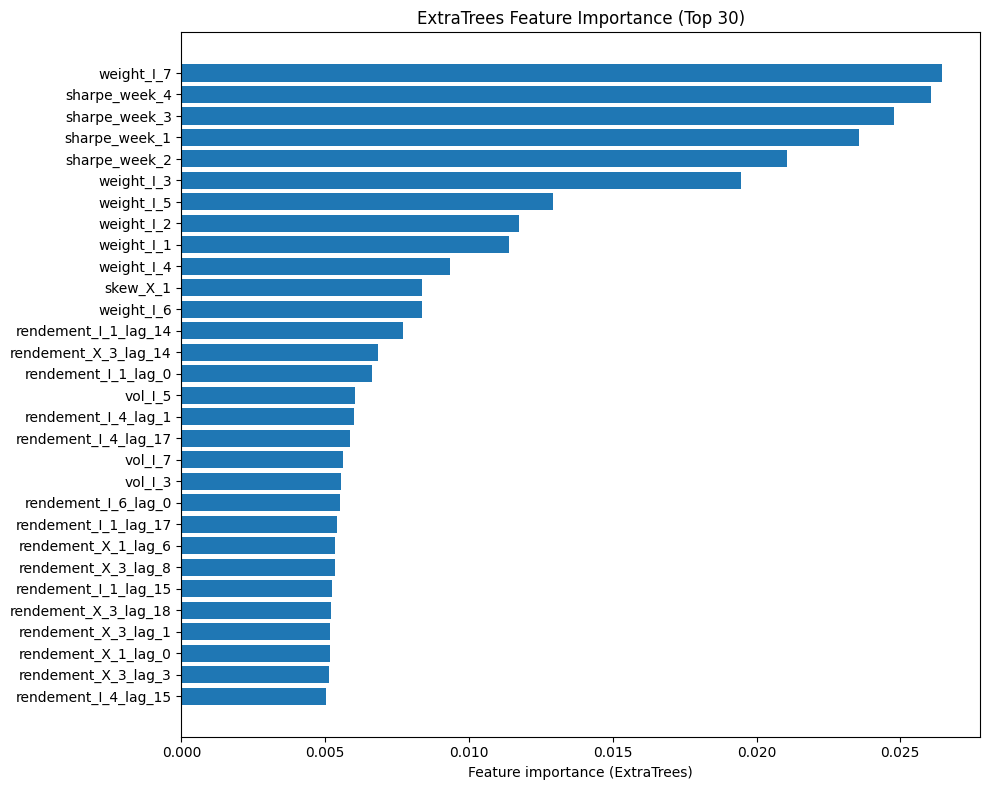

In [82]:
# Modèle ExtraTrees entraîné
etr_model = etr_final.named_steps["model"]

importances = etr_model.feature_importances_
feature_names = X_trval.columns

fi_etr = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

top_k = 30
fi_top = fi_etr.head(top_k).iloc[::-1]  

plt.figure(figsize=(10, 8))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.xlabel("Feature importance (ExtraTrees)")
plt.title(f"ExtraTrees Feature Importance (Top {top_k})")
plt.tight_layout()
plt.show()

### 3.4 XgBoost 

Par défaut, les modèles de gradient boosting tels que XGBoost sont généralement entraînés en minimisant une erreur quadratique moyenne (Mean Squared Error, MSE), qui pénalise fortement les erreurs de grande amplitude. Ce choix est bien adapté à des variables cibles proches d’une distribution gaussienne et peu sujettes aux valeurs extrêmes. Toutefois, dans notre cas, la distribution est fortement étalée et présente des valeurs extrêmes dues à la nature très volatile des actifs sous-jacents. L’utilisation de la MSE conduit les modèles à sur-pondérer ces observations extrêmes, souvent dominées par le bruit, au détriment de la structure moyenne du signal. Afin de limiter cet effet, nous avons remplacé la loss quadratique par une loss robuste de type Pseudo-Huber, qui combine un comportement quadratique pour les erreurs modérées et linéaire pour les erreurs importantes. Ce compromis permet de réduire l’influence des valeurs aberrantes tout en conservant une fonction de perte différentiable, adaptée à l’optimisation par gradient. En testant un modèle avec la MSE nous confirmons que la performance est moins bonne. 

#### XGBoost - Modèle (4)

In [84]:
# Cibles sous forme de tableaux 1D
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# Tuning XGBoost :
# - early stopping sur la validation
# - sélection du meilleur modèle via MAE sur la validation
# - refit final sur Train+Val
xgb_space_huber = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.005, 0.01, 0.02, 0.03],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "colsample_bynode": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 5],
    "gamma": [0.0],
    "reg_alpha": [0.0, 1e-3, 1e-2],
    "reg_lambda": [1.0, 2.0, 5.0],
    "n_estimators": [8000],
}

best_val = np.inf
best_params = None
best_n_estimators = None

for i, params in enumerate(
    ParameterSampler(xgb_space_huber, n_iter=cfg.n_iter_fast, random_state=cfg.seed),
    start=1
):
    # Modèle avec loss Huber (pseudo-huber) et early stopping
    model = XGBRegressor(
        # random_state=cfg.seed,
        tree_method="hist",
        objective="reg:pseudohubererror",
        n_jobs=-1,
        verbosity=0,
        eval_metric="mae",
        early_stopping_rounds=200,
        **params
    )

    # Entraînement sur Train, arrêt anticipé basé sur la VAL
    model.fit(
        X_train, ytr,
        eval_set=[(X_val, yva)],
        verbose=False
    )

    # Score de validation pour choisir les hyperparamètres
    pred_val = model.predict(X_val).ravel()
    val_score = mean_absolute_error(yva, pred_val)

    # Nombre d'arbres retenu par l'early stopping
    best_iter = getattr(model, "best_iteration", None)
    n_best = (best_iter + 1) if best_iter is not None else params["n_estimators"]

    print(f"[{i:02d}/{cfg.n_iter_fast}] VAL={val_score:.4f}  best_iter={best_iter}  n_best={n_best}  params={params}")

    if val_score < best_val:
        best_val = val_score
        best_params = params
        best_n_estimators = int(n_best)

print("\nXGB best on VAL (Huber):", best_val)
print("Best params:", best_params)
print("Best n_estimators (from early stopping):", best_n_estimators)

# Refit sur Train+Val avec n_estimators fixé au meilleur nombre d'itérations
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

xgb_4 = XGBRegressor(
    random_state=cfg.seed,
    tree_method="hist",
    objective="reg:pseudohubererror",
    n_jobs=-1,
    verbosity=0,
    eval_metric="mae",
    n_estimators=best_n_estimators,
    **{k: v for k, v in best_params.items() if k != "n_estimators"}
)

xgb_4.fit(X_trval, y_trval, verbose=False)

# Évaluation sur le jeu de test
pred_test = xgb_4.predict(X_test).ravel()
test_mae = mean_absolute_error(yte, pred_test)

print("\nXGB TEST (Huber):")
print("MAE:", test_mae)

# Diagnostics simples
corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]
print("\nDiagnostics:")
print("corr(pred,y):", corr)
print("std(pred), std(y):", np.std(pred_test), np.std(yte))


[01/10] VAL=4.3786  best_iter=0  n_best=1  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'n_estimators': 8000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0}
[02/10] VAL=4.3472  best_iter=1  n_best=2  params={'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.01, 'n_estimators': 8000, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.0, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6}
[03/10] VAL=4.3640  best_iter=1  n_best=2  params={'subsample': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 0.001, 'n_estimators': 8000, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.02, 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8}
[04/10] VAL=4.3684  best_iter=0  n_best=1  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'n_estimators': 8000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsa

Les résultats du XGBoost (4) ont encore la même signification que ceux précédents, c'est particulièrement visible ici. La MAE et la corrélation indiquent que la prédiction est meilleur que le benchmark et que ce n'est pas du bruit. En revanche l'écart-type indique que les prédictions sont très peu dispersées. De plus le modèle retient seulement deux arbres ce qui est très faible. Le modèle est simple et très régularisé. Nous tentons de "forcer" une plus grande flexibilité dans le modèle XGBoost suivant en imposant un nombre d'arbres minimum de 50. Le résultat montre que cela conduit simplement à de l'overfitting et dégrade la performance. 

#### XGBoost - Modèle test

In [71]:
# Cibles sous forme de tableaux 1D
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# Espace de recherche des hyperparamètres XGB
xgb_space_huber = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.005, 0.01, 0.02, 0.03],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "colsample_bynode": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 5],
    "gamma": [0.0],
    "reg_alpha": [0.0, 1e-3, 1e-2],
    "reg_lambda": [1.0, 2.0, 5.0],
    "n_estimators": [8000],
}

best_val = np.inf
best_params = None
best_n_estimators_es = None  # valeur issue de l’early stopping

# Tuning sur la validation avec early stopping
for i, params in enumerate(
    ParameterSampler(xgb_space_huber, n_iter=cfg.n_iter_fast, random_state=cfg.seed),
    start=1
):
    model = XGBRegressor(
        random_state=cfg.seed,
        tree_method="hist",
        objective="reg:pseudohubererror",
        n_jobs=-1,
        verbosity=0,
        eval_metric="mae",
        early_stopping_rounds=200,
        **params
    )

    model.fit(
        X_train, ytr,
        eval_set=[(X_val, yva)],
        verbose=False
    )

    # Score sur la validation pour sélectionner les paramètres
    pred_val = model.predict(X_val).ravel()
    val_score = mean_absolute_error(yva, pred_val)

    # Nombre d’arbres retenu par l’early stopping
    best_iter = getattr(model, "best_iteration", None)
    n_best = (best_iter + 1) if best_iter is not None else params["n_estimators"]

    print(f"[{i:02d}/{cfg.n_iter_fast}] VAL={val_score:.4f}  best_iter={best_iter}  n_best={n_best}  params={params}")

    if val_score < best_val:
        best_val = val_score
        best_params = params
        best_n_estimators_es = int(n_best)

print("\nXGB best on VAL (Huber):", best_val)
print("Best params:", best_params)
print("Best n_estimators (from early stopping):", best_n_estimators_es)

# Refit sur Train+Val en imposant un minimum d’arbres
n_min_trees = 50  # force un apprentissage minimal
best_n_estimators_forced = max(best_n_estimators_es, n_min_trees)

print("Forced n_estimators used for final refit:", best_n_estimators_forced)

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

xgb_final = XGBRegressor(
    random_state=cfg.seed,
    tree_method="hist",
    objective="reg:pseudohubererror",
    n_jobs=-1,
    verbosity=0,
    eval_metric="mae",
    n_estimators=best_n_estimators_forced,
    **{k: v for k, v in best_params.items() if k != "n_estimators"}
)

xgb_final.fit(X_trval, y_trval, verbose=False)

# Évaluation sur le jeu de test
pred_test = xgb_final.predict(X_test).ravel()
test_mae = mean_absolute_error(yte, pred_test)

print("\nXGB TEST (Huber, forced trees):")
print("MAE:", test_mae)

# Diagnostics simples
corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]
print("\nDiagnostics:")
print("corr(pred,y):", corr)
print("std(pred), std(y):", np.std(pred_test), np.std(yte))


[01/10] VAL=4.3803  best_iter=1  n_best=2  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'n_estimators': 8000, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.9, 'colsample_bynode': 1.0}
[02/10] VAL=4.3437  best_iter=1  n_best=2  params={'subsample': 1.0, 'reg_lambda': 2.0, 'reg_alpha': 0.01, 'n_estimators': 8000, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.0, 'colsample_bytree': 0.7, 'colsample_bynode': 0.6}
[03/10] VAL=4.3640  best_iter=1  n_best=2  params={'subsample': 1.0, 'reg_lambda': 5.0, 'reg_alpha': 0.001, 'n_estimators': 8000, 'min_child_weight': 2, 'max_depth': 2, 'learning_rate': 0.02, 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsample_bynode': 0.8}
[04/10] VAL=4.3687  best_iter=0  n_best=1  params={'subsample': 0.8, 'reg_lambda': 5.0, 'reg_alpha': 0.0, 'n_estimators': 8000, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsa

### 3.5 MLP (Keras)

Pour le modèle MLP, les hyperparamètres testés et choisis à l'aide du validation set correspondent à un modèle simple avec peu de couches cachés (1 ou 2) et peu de neurones (entre 16 et 64). Des modèles plus complexes n'auraient pas trop de sens au vu des données et des résultats des modèles précédents.

#### MLP - Modèle test : trop instable 

In [ ]:
# Espace de recherche des hyperparamètres (MLP classique)
mlp_space_classic = {
    # architectures simples pour données tabulaires
    "hidden_units": [(64,), (128,), (64, 32)],
    # dropout pour limiter l’overfitting
    "dropout": [0.0, 0.2, 0.4],
    # régularisation L2
    "l2_reg": [0.0, 1e-4, 1e-2, 1e-1],
    # taux d’apprentissage pour Adam
    "learning_rate": [1e-2, 1e-3, 3e-4],
    "batch_size": [64, 128],
    "epochs": [200],  # plafond : l’early stopping décide du nombre réel d’époques
}

# Cibles sous forme de tableaux 1D
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# Standardisation : fit sur Train uniquement (anti-leakage)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

best_val = np.inf
best_params = None
best_epoch = None

# Tuning : entraînement sur Train, sélection sur Validation
for i, params in enumerate(ParameterSampler(mlp_space_classic, n_iter=30, random_state=42), start=1):
    tf.keras.backend.clear_session()

    model = build_mlp(
        input_dim=X_train_s.shape[1],
        hidden_units=params["hidden_units"],
        dropout=params["dropout"],
        l2_reg=params["l2_reg"],
        learning_rate=params["learning_rate"],
    )

    # Early stopping basé sur la loss de validation
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
        verbose=0
    )

    hist = model.fit(
        X_train_s, ytr,
        validation_data=(X_val_s, yva),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[es],
        verbose=0,
        shuffle=True
    )

    pred_val = model.predict(X_val_s, verbose=0).ravel()
    val_mae = mean_absolute_error(yva, pred_val)

    # Epoch correspondant au meilleur val_loss observé
    this_best_epoch = int(np.argmin(hist.history["val_loss"]) + 1)
    print(f"[{i:02d}] VAL={val_mae:.4f} best_epoch={this_best_epoch} params={params}")

    if val_mae < best_val:
        best_val = val_mae
        best_params = params
        best_epoch = this_best_epoch

print(f"\nBest VAL (classic MLP): {best_val:.4f}")
print("Best params:", best_params)
print("Best epoch:", best_epoch)

# Refit final : Train+Val, scaler refit sur Train+Val, test inchangé
print("\nRefitting best model on Train+Val...")

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

scaler_final = StandardScaler()
X_trval_s = scaler_final.fit_transform(X_trval)
X_test_s2 = scaler_final.transform(X_test)

tf.keras.backend.clear_session()
model_final = build_mlp(
    input_dim=X_trval_s.shape[1],
    hidden_units=best_params["hidden_units"],
    dropout=best_params["dropout"],
    l2_reg=best_params["l2_reg"],
    learning_rate=best_params["learning_rate"],
)

# Entraînement jusqu’à best_epoch (déterminé sur la validation)
model_final.fit(
    X_trval_s,
    y_trval,
    epochs=best_epoch,
    batch_size=best_params["batch_size"],
    verbose=0,
    shuffle=True
)

# Évaluation finale sur le test
pred_test = model_final.predict(X_test_s2, verbose=0).ravel()
test_mae = mean_absolute_error(yte, pred_test)
corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]

print("\nTEST RESULTS:")
print(f"MAE:  {test_mae:.4f}")
print(f"Corr: {corr:.4f}")
print(f"std : {np.std(pred_test):.4f}")



[01] VAL=4.4810 best_epoch=29 params={'learning_rate': 0.01, 'l2_reg': 0.1, 'hidden_units': (128,), 'epochs': 200, 'dropout': 0.4, 'batch_size': 128}
[02] VAL=4.5273 best_epoch=43 params={'learning_rate': 0.01, 'l2_reg': 0.1, 'hidden_units': (64, 32), 'epochs': 200, 'dropout': 0.4, 'batch_size': 128}
[03] VAL=4.8485 best_epoch=24 params={'learning_rate': 0.01, 'l2_reg': 0.01, 'hidden_units': (64, 32), 'epochs': 200, 'dropout': 0.0, 'batch_size': 128}
[04] VAL=4.4167 best_epoch=15 params={'learning_rate': 0.01, 'l2_reg': 0.1, 'hidden_units': (64, 32), 'epochs': 200, 'dropout': 0.2, 'batch_size': 128}
[05] VAL=4.9824 best_epoch=2 params={'learning_rate': 0.01, 'l2_reg': 0.0001, 'hidden_units': (128,), 'epochs': 200, 'dropout': 0.0, 'batch_size': 64}
[06] VAL=4.9741 best_epoch=2 params={'learning_rate': 0.01, 'l2_reg': 0.0001, 'hidden_units': (64,), 'epochs': 200, 'dropout': 0.0, 'batch_size': 128}
[07] VAL=4.4056 best_epoch=1 params={'learning_rate': 0.0003, 'l2_reg': 0.0, 'hidden_units

La première différence majeure que nous observons avec le modèle MLP est l'instabilité de ce-dernier. D'une seed à l'autre les résultats obtenus sont très différents, ce qui n'est pas le cas avec nos autres modèles. Pour Random Forest l’agrégation de nombreux arbres réduit l'aléa, en boosting, l’agrégation séquentielle a le même effet. Mais pour un MLP l'aléa a beaucoup d'impact. Une des raisons est que les fonctions de pertes sont convexes par rapport aux prédictions mais pas par rapport aux paramètres. L'initialisation aléatoire des paramètres conduit donc à des solutions différentes entre deux entraînement (différents minima locaux). Nous observons une instabilité des résultats des modèles MLP, malgré des solutions de régularisation comme la normalisation des données, une régularisation L2, un "early stop", un paramètre de "drop out" et une architecture simple. Comme pour les autres hyperparamètres, l'early stop est déterminé à l'aide du validation set. Par ailleurs, nous n'avons pas modifié l'initialisation des paramètres, par défaut Keras utilise la méthode de Xavier avec fonction uniforme. 

Une régularisation trop forte peut provoquer de l'instabilité, c'est le cas lorsque le modèle ne capte pas assez de signal et que l’entraînement est rendu très aléatoire par l'initialisation, un taux de drop out élevé et un "early stop" tôt. Nous essayons donc un second modèle avec une grille d'hyperparamètres (toujours sélectionnés grâce au validation set) raisonnable qui limite la régularisation. Cela stabilise un peu le modèle mais celui-ci reste tout de même assez instable.

#### MLP - Modèle test numéro 2 avec taux de dropout et régularisation plus faible : un peu instable

In [ ]:
# Espace de recherche orienté stabilité (réseaux petits, LR faible, régularisation fine)
mlp_space_stable = {
    "hidden_units": [(16,), (32,), (32, 16)],          # réseaux plus petits -> moins de variance
    "dropout": [0.0, 0.1],                             # peu ou pas de dropout
    "l2_reg": [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],          # grille plus fine
    "learning_rate": [1e-3, 5e-4, 2e-4, 1e-4],         # LR plus faible pour stabiliser
    "batch_size": [64, 128],
    "epochs": [250],                                   # plafond : early stopping décide
}



# Cibles sous forme de tableaux 1D
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# Standardisation : fit sur Train uniquement
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

best_val = np.inf
best_params = None
best_epoch = None

# Tuning : entraînement sur Train, sélection sur Validation
for i, params in enumerate(ParameterSampler(mlp_space_stable, n_iter=30, random_state=42), start=1):
    tf.keras.backend.clear_session()

    model = build_mlp(
        X_train_s.shape[1],
        params["hidden_units"],
        params["dropout"],
        params["l2_reg"],
        params["learning_rate"],
    )

    # Patience plus élevée pour lisser le bruit dans la val_loss
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True,
        verbose=0
    )

    hist = model.fit(
        X_train_s, ytr,
        validation_data=(X_val_s, yva),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[es],
        verbose=0,
        shuffle=True
    )

    pred_val = model.predict(X_val_s, verbose=0).ravel()
    val_mae = mean_absolute_error(yva, pred_val)

    this_best_epoch = int(np.argmin(hist.history["val_loss"]) + 1)

    print(f"[{i:02d}] VAL={val_mae:.4f} best_epoch={this_best_epoch} params={params}")

    if val_mae < best_val:
        best_val = val_mae
        best_params = params
        best_epoch = this_best_epoch

print(f"\nBest VAL (stable MLP): {best_val:.4f}")
print("Best params:", best_params)
print("Best epoch:", best_epoch)

# Refit final sur Train+Val, scaler refit sur Train+Val
print("\nRefitting best model on Train+Val...")

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

scaler_final = StandardScaler()
X_trval_s = scaler_final.fit_transform(X_trval)
X_test_s2 = scaler_final.transform(X_test)

tf.keras.backend.clear_session()
model_final = build_mlp(
    X_trval_s.shape[1],
    hidden_units=best_params["hidden_units"],
    dropout=best_params["dropout"],
    l2_reg=best_params["l2_reg"],
    learning_rate=best_params["learning_rate"],
)

# Entraînement sur best_epoch (déterminé sur la validation)
model_final.fit(
    X_trval_s,
    y_trval,
    epochs=best_epoch,
    batch_size=best_params["batch_size"],
    verbose=0,
    shuffle=True
)

# Évaluation sur le test
pred_test = model_final.predict(X_test_s2, verbose=0).ravel()
test_mae = mean_absolute_error(yte, pred_test)
corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]

print("\nTEST RESULTS:")
print(f"MAE:  {test_mae:.4f}")
print(f"Corr: {corr:.4f}")
print(f"std : {np.std(pred_test):.4f}")


[01] VAL=4.7168 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.0005, 'hidden_units': (32,), 'epochs': 250, 'dropout': 0.0, 'batch_size': 64}
[02] VAL=4.6085 best_epoch=1 params={'learning_rate': 0.0002, 'l2_reg': 0.0005, 'hidden_units': (16,), 'epochs': 250, 'dropout': 0.0, 'batch_size': 64}
[03] VAL=4.7769 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.005, 'hidden_units': (32,), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[04] VAL=4.5781 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.001, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[05] VAL=4.5549 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.0005, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[06] VAL=4.6459 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.005, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.0, 'batch_size': 128}
[07] VAL=4.4795 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.005, 'hidd

 Le problème qui persiste est que l’early stopping s’active souvent très tôt (parfois à la première "epoch"), en raison du faible signal et du bruit dans la cible. Cela cause l'instabilité du modèle. Pour résoudre ce problème nous fixons alors le nombre d'epoch minimal à 10, mais cela ne stabilise toujours pas le modèle. 

#### MLP - Modèle test numéro 3 avec taux de dropout et régularisation plus faible et un nombre d'"epoch" minimal de 10

In [ ]:
# Espace de recherche orienté stabilité
mlp_space_stable = {
    "hidden_units": [(16,), (32,), (32, 16)],
    "dropout": [0.0, 0.1],
    "l2_reg": [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    "learning_rate": [1e-3, 5e-4, 2e-4, 1e-4],
    "batch_size": [64, 128],
    "epochs": [250],
}

# Cibles sous forme de tableaux 1D
ytr = Y_train["Target"].to_numpy().ravel()
yva = Y_val["Target"].to_numpy().ravel()
yte = Y_test["Target"].to_numpy().ravel()

# Standardisation : fit sur Train uniquement
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

best_val = np.inf
best_params = None
best_epoch = None

# Tuning : entraînement sur Train, sélection sur Validation
for i, params in enumerate(ParameterSampler(mlp_space_stable, n_iter=30, random_state=42), start=1):
    tf.keras.backend.clear_session()

    model = build_mlp(
        X_train_s.shape[1],
        params["hidden_units"],
        params["dropout"],
        params["l2_reg"],
        params["learning_rate"],
    )

    # Early stopping plus patient pour éviter de stopper trop tôt
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True,
        verbose=0
    )

    hist = model.fit(
        X_train_s, ytr,
        validation_data=(X_val_s, yva),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        callbacks=[es],
        verbose=0,
        shuffle=True
    )

    pred_val = model.predict(X_val_s, verbose=0).ravel()
    val_mae = mean_absolute_error(yva, pred_val)

    # Meilleure epoch selon val_loss
    this_best_epoch = int(np.argmin(hist.history["val_loss"]) + 1)

    print(f"[{i:02d}] VAL={val_mae:.4f} best_epoch={this_best_epoch} params={params}")

    if val_mae < best_val:
        best_val = val_mae
        best_params = params
        best_epoch = this_best_epoch

print(f"\nBest VAL (stable MLP): {best_val:.4f}")
print("Best params:", best_params)
print("Best epoch (val):", best_epoch)

# Refit final sur Train+Val avec un minimum d’époques
print("\nRefitting best model on Train+Val (epoch floor = 10)...")

final_epochs = max(best_epoch, 10)
print("Final epochs used:", final_epochs)

X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = np.concatenate([ytr, yva], axis=0)

scaler_final = StandardScaler()
X_trval_s = scaler_final.fit_transform(X_trval)
X_test_s2 = scaler_final.transform(X_test)

tf.keras.backend.clear_session()
model_final = build_mlp(
    X_trval_s.shape[1],
    hidden_units=best_params["hidden_units"],
    dropout=best_params["dropout"],
    l2_reg=best_params["l2_reg"],
    learning_rate=best_params["learning_rate"],
)

model_final.fit(
    X_trval_s,
    y_trval,
    epochs=final_epochs,
    batch_size=best_params["batch_size"],
    verbose=0,
    shuffle=True
)

# Évaluation sur le test
pred_test = model_final.predict(X_test_s2, verbose=0).ravel()
test_mae = mean_absolute_error(yte, pred_test)
corr = 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1]

print("\nTEST RESULTS:")
print(f"MAE:  {test_mae:.4f}")
print(f"Corr: {corr:.4f}")
print(f"std : {np.std(pred_test):.4f}")


[01] VAL=4.8997 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.0005, 'hidden_units': (32,), 'epochs': 250, 'dropout': 0.0, 'batch_size': 64}
[02] VAL=4.7066 best_epoch=3 params={'learning_rate': 0.0002, 'l2_reg': 0.0005, 'hidden_units': (16,), 'epochs': 250, 'dropout': 0.0, 'batch_size': 64}
[03] VAL=4.5115 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.005, 'hidden_units': (32,), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[04] VAL=4.5333 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.001, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[05] VAL=4.7376 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.0005, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.1, 'batch_size': 64}
[06] VAL=4.7178 best_epoch=1 params={'learning_rate': 0.001, 'l2_reg': 0.005, 'hidden_units': (32, 16), 'epochs': 250, 'dropout': 0.0, 'batch_size': 128}
[07] VAL=4.5983 best_epoch=1 params={'learning_rate': 0.0005, 'l2_reg': 0.005, 'hidd

#### MLP - Modèle (5) ensemble de MLP  

In [75]:
# Plusieurs seeds pour tester la robustesse du MLP
seeds = [0, 1, 2, 3, 4]

preds_test_all = []   # stocke les prédictions test pour chaque seed
results = []

for seed in seeds:
    print(f"\n===== SEED {seed} =====")
    tf.keras.utils.set_random_seed(seed)
    tf.keras.backend.clear_session()

    # Standardisation : fit sur Train uniquement
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s   = scaler.transform(X_val)
    X_test_s  = scaler.transform(X_test)

    # Cibles 1D
    ytr = Y_train["Target"].to_numpy().ravel()
    yva = Y_val["Target"].to_numpy().ravel()
    yte = Y_test["Target"].to_numpy().ravel()

    best_val = np.inf
    best_params = None
    best_epoch = None

    # Tuning sur la validation (random search + early stopping)
    for params in ParameterSampler(mlp_space_classic, n_iter=30, random_state=seed):
        tf.keras.backend.clear_session()

        model = build_mlp(
            X_train_s.shape[1],
            params["hidden_units"],
            params["dropout"],
            params["l2_reg"],
            params["learning_rate"],
        )

        es = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=30,
            restore_best_weights=True,
            verbose=0
        )

        hist = model.fit(
            X_train_s, ytr,
            validation_data=(X_val_s, yva),
            epochs=params["epochs"],
            batch_size=params["batch_size"],
            callbacks=[es],
            verbose=0,
            shuffle=True
        )

        pred_val = model.predict(X_val_s, verbose=0).ravel()
        val_mae = mean_absolute_error(yva, pred_val)

        # Meilleure epoch selon la val_loss
        epoch_best = int(np.argmin(hist.history["val_loss"]) + 1)

        if val_mae < best_val:
            best_val = val_mae
            best_params = params
            best_epoch = epoch_best

    # Refit sur Train+Val avec les meilleurs hyperparamètres
    X_trval = pd.concat([X_train, X_val], axis=0)
    y_trval = np.concatenate([ytr, yva], axis=0)

    scaler_final = StandardScaler()
    X_trval_s = scaler_final.fit_transform(X_trval)
    X_test_s2 = scaler_final.transform(X_test)

    tf.keras.backend.clear_session()
    model_final = build_mlp(
        X_trval_s.shape[1],
        hidden_units=best_params["hidden_units"],
        dropout=best_params["dropout"],
        l2_reg=best_params["l2_reg"],
        learning_rate=best_params["learning_rate"],
    )

    model_final.fit(
        X_trval_s,
        y_trval,
        epochs=best_epoch,
        batch_size=best_params["batch_size"],
        verbose=0,
        shuffle=True
    )

    # Prédictions sur le test pour cette seed
    pred_test = model_final.predict(X_test_s2, verbose=0).ravel()

    preds_test_all.append(pred_test)

    # Résumé des scores et des choix de paramètres
    results.append({
        "seed": seed,
        "MAE": mean_absolute_error(yte, pred_test),
        "Corr": 0.0 if np.std(pred_test) < 1e-12 else np.corrcoef(pred_test, yte)[0, 1],
        "Std_pred": np.std(pred_test),
        "dropout": best_params["dropout"],
        "l2_reg": best_params["l2_reg"],
        "best_epoch": best_epoch,
    })

# Ensemble : moyenne des prédictions sur les 5 seeds
preds_test_all = np.vstack(preds_test_all)
pred_ensemble = preds_test_all.mean(axis=0)

mae_ens = mean_absolute_error(yte, pred_ensemble)
corr_ens = 0.0 if np.std(pred_ensemble) < 1e-12 else np.corrcoef(pred_ensemble, yte)[0, 1]
std_ens = np.std(pred_ensemble)

print("\n===== ENSEMBLE RESULTS (mean over 5 seeds) =====")
print(f"MAE  : {mae_ens:.4f}")
print(f"Corr : {corr_ens:.4f}")
print(f"Std  : {std_ens:.4f}")

# Tableau récapitulatif des runs individuels
results_df = pd.DataFrame(results)
print("\n=== INDIVIDUAL RUNS ===")
print(results_df)

# Moyenne et écart-type sur les modèles individuels
print("\n=== MEAN ± STD (individual models) ===")
print(results_df[["MAE", "Corr", "Std_pred"]].agg(["mean", "std"]))



===== SEED 0 =====

===== SEED 1 =====

===== SEED 2 =====

===== SEED 3 =====

===== SEED 4 =====

===== ENSEMBLE RESULTS (mean over 5 seeds) =====
MAE  : 4.3092
Corr : 0.2018
Std  : 0.7135

=== INDIVIDUAL RUNS ===
   seed       MAE      Corr  Std_pred  dropout  l2_reg  best_epoch
0     0  4.376271  0.128453  1.116776      0.2  0.0001           1
1     1  4.310224  0.149403  1.135365      0.4  0.0000           1
2     2  4.310710  0.266514  0.591956      0.4  0.0000           1
3     3  4.301373  0.272964  0.626577      0.2  0.0000           1
4     4  4.498976  0.049987  1.560226      0.2  0.1000          27

=== MEAN ± STD (individual models) ===
           MAE      Corr  Std_pred
mean  4.359511  0.173464  1.006180
std   0.083550  0.095407  0.403599


Les prédictions finales, modèle (6) sont obtenues en agrégeant cinq réseaux de neurones entraînés avec des initialisations différentes, ce qui constitue une forme simple d’ensemble visant à réduire la variance du modèle. Pris individuellement, les réseaux de neurones présentent une forte variabilité selon l’initialisation et des performances instables. En revanche, l’agrégation des prédictions de plusieurs MLP permet de réduire significativement la variance et d’améliorer la performance globale, confirmant l’intérêt d’une approche en ensemble dans ce contexte bruité.